# 10. Visualize taxonomy at different taxonomical levels 

In [13]:
library(tidyverse)
library(data.table)
library(reshape2)
library(ggplot2)
library(RColorBrewer)
library(vegan)
library(phyloseq)
library(dplyr) 
library(ggpubr)
library(Hmisc)
library(corrplot)
library(scales)
library(broom)
library(ecodist)
library(patchwork)
library(ggsignif)
library(FSA)
library(rstatix)

In [14]:
## Create color palette
purples <- brewer.pal(n = 5, name = "BuPu")[-c(1:4)] # taking a few colors from the RColorBrewer Package
blues <- rev(brewer.pal(n = 5, name = "Blues")[-1])
greens <- brewer.pal(n = 5, name = "YlGn")[-1]
oranges <- c("#FFEC8B", "#FECC5C", "#fe9a4d", "#fe6f01") # appending some nice oranges, reds, purples, beiges and aquamarines
reds <- c("#b30024", "#ff0033", "#ff554d", "#ff9e99")
purples <- append(purples, c("#ac39ac", "#cc66cc", "#ffb3ff"))
beiges <- c("#999966", "#adad85", "#ccccb3")
aquamarines <- c("#25a696", "#43d6c5", "#96e8df")
pinks <- c("#9F2B68", "#F33A6A")
gray <- c("#808080")
custom_colors <- c(blues, reds, oranges, greens, purples, rev(beiges), aquamarines, pinks) # combinig all colors in a single vector

In [28]:
# Load data
setwd("/home/strawberry/Documents/Collaborations/sinusite_edwin/data")

ReadCounts_TaxAnnotation <- read.delim("./ReadCounts_TaxAnnotation_SILVA.tsv")
metadata_filtered <- read.delim("./metadata_filtered_Diversity.tsv")

print(head(ReadCounts_TaxAnnotation))
print(head(metadata_filtered))

    ID_Sample           id count  Kingdom         Phylum          Class
1 0001967K_T1     AB646616     1 Bacteria      Bacillota        Bacilli
2 0001967K_T1     AF015929     4 Bacteria      Bacillota        Bacilli
3 0001967K_T1 AGEF01000005     1 Bacteria      Bacillota        Bacilli
4 0001967K_T1 AIYD01000002     2 Bacteria      Bacillota        Bacilli
5 0001967K_T1     AJ439343     1 Bacteria Actinomycetota Actinobacteria
6 0001967K_T1     AJ938182     1 Bacteria      Bacillota        Bacilli
             Order             Family           Genus
1 Staphylococcales  Staphylococcaceae  Staphylococcus
2 Staphylococcales  Staphylococcaceae  Staphylococcus
3  Lactobacillales  Carnobacteriaceae  Dolosigranulum
4 Staphylococcales  Staphylococcaceae  Staphylococcus
5  Mycobacteriales Corynebacteriaceae Corynebacterium
6 Staphylococcales  Staphylococcaceae  Staphylococcus
                               Species total_aligned RelativeAbundance SNOT22
1       Staphylococcus saccharolyticus  

In [4]:
# colnames(ReadCounts_TaxAnnotation)
# colnames(metadata_filtered)

Warning message:
“Use of `df_relab_tax_filt$Taxa` is discouraged.
ℹ Use `Taxa` instead.”
Warning message:
“Use of `df_relab_tax_filt$Taxa` is discouraged.
ℹ Use `Taxa` instead.”
Warning message:
“Use of `df_relab_tax_filt$Taxa` is discouraged.
ℹ Use `Taxa` instead.”
Warning message:
“Use of `df_relab_tax_filt$Taxa` is discouraged.
ℹ Use `Taxa` instead.”


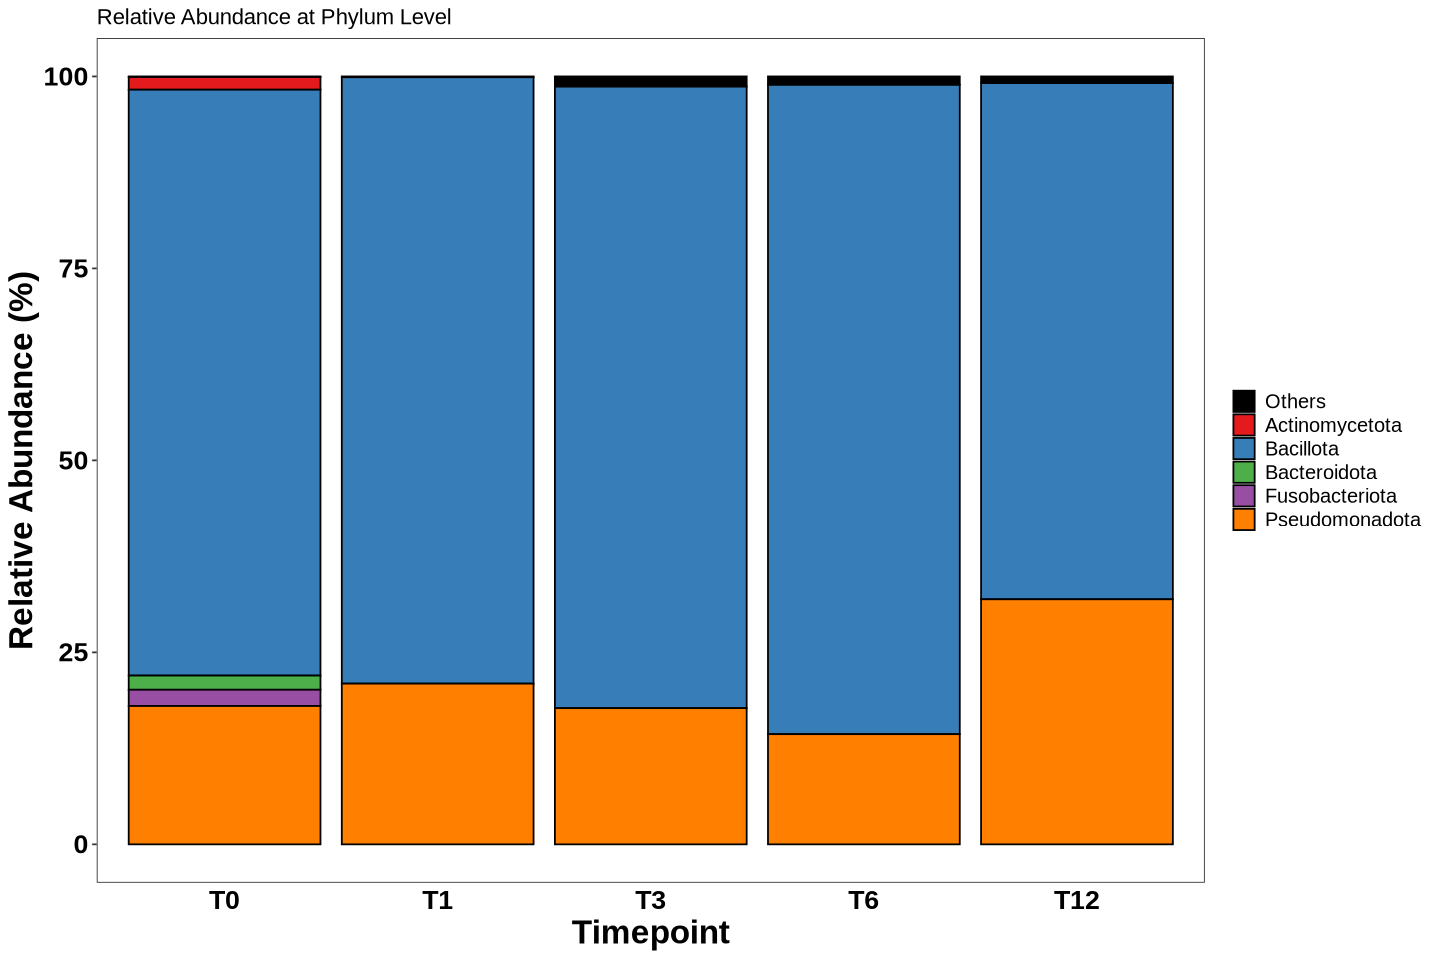

Warning message:
“Use of `df_relab_tax_filt$Taxa` is discouraged.
ℹ Use `Taxa` instead.”
Warning message:
“Use of `df_relab_tax_filt$Taxa` is discouraged.
ℹ Use `Taxa` instead.”


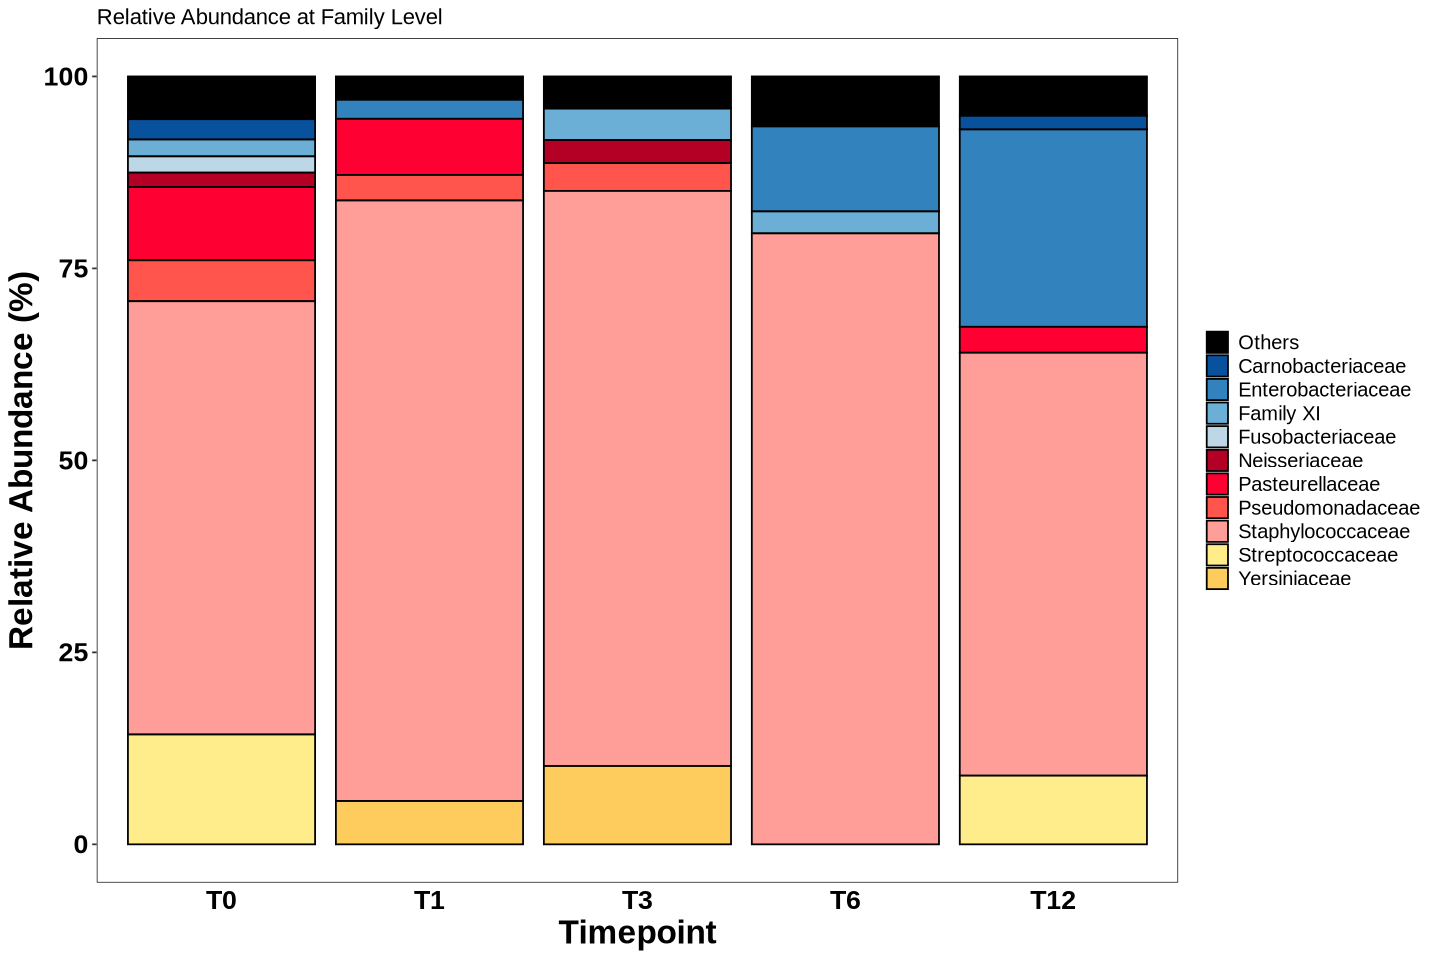

Warning message:
“Use of `df_relab_tax_filt$Taxa` is discouraged.
ℹ Use `Taxa` instead.”
Warning message:
“Use of `df_relab_tax_filt$Taxa` is discouraged.
ℹ Use `Taxa` instead.”


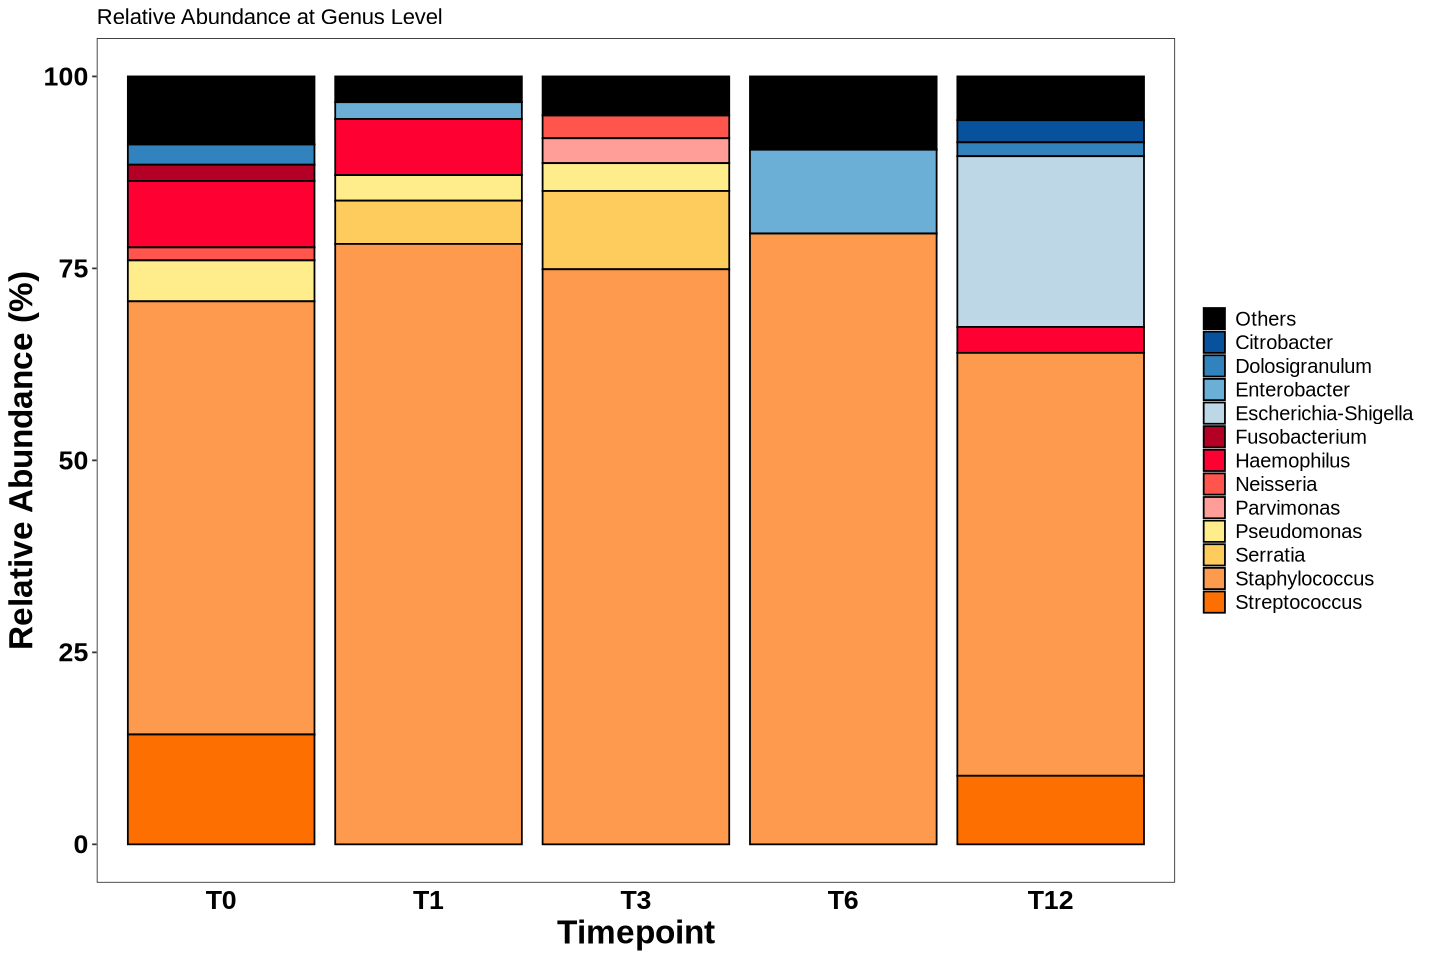

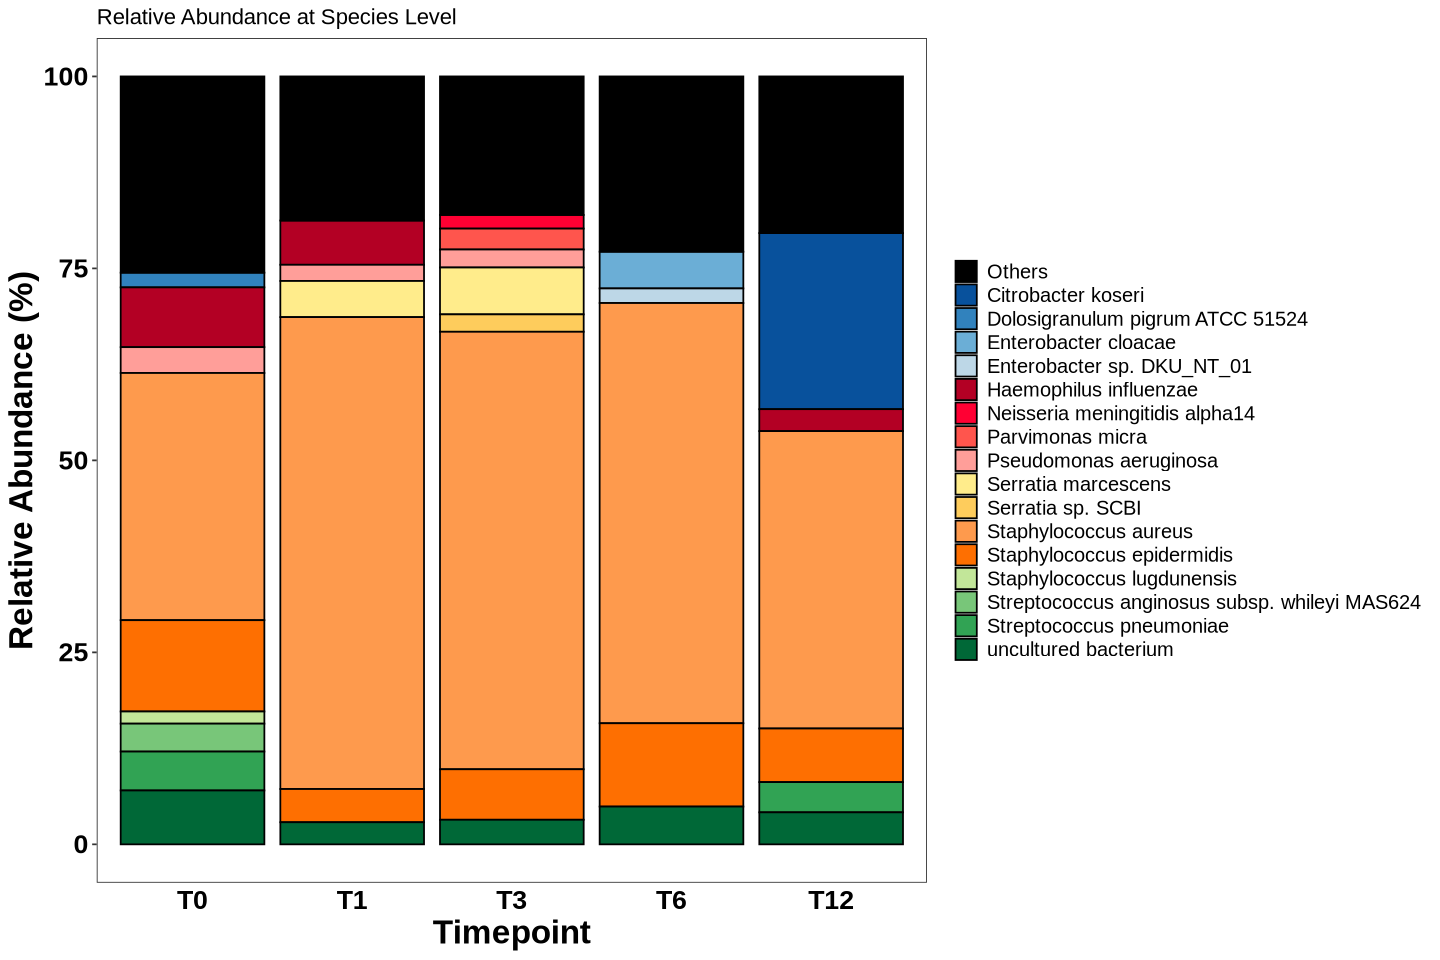

In [29]:
# Define function to process and plot relative abundance at different taxonomy levels
plot_relative_abundance <- function(data, tax_level, output_file) {
  
  # Aggregate counts at the specified taxonomic level
  df_tax <- aggregate(data$count, 
                      list(data[[tax_level]], data$ID_Sample, data$Timepoint), 
                      FUN=sum)
  colnames(df_tax) <- c("Taxa", "ID_Sample", "Timepoint", "Counts")

  # Create relative abundance data
  cast_data_tax <- acast(df_tax, Timepoint ~ Taxa, value.var = "Counts", fun.aggregate = sum)
  cast_data_tax[is.na(cast_data_tax)] <- 0  # Replace missing values with 0

  # Calculating relative abundance
  tcast_data_tax <- t(cast_data_tax)
  relative_abundance_tax <- (t(tcast_data_tax) / apply(tcast_data_tax, 2, sum)) * 100
  df_relab_tax <- melt(relative_abundance_tax) # Reshape data frame

  # Rename columns
  colnames(df_relab_tax) <- c("Timepoint", "Taxa", "RelativeAbundance") 
  df_relab_tax <- df_relab_tax[-which(df_relab_tax$RelativeAbundance == 0),] # Remove rows with zero relative abundance

  # Filter taxa above threshold (e.g., 1.5%)
  df_relab_tax_filt <- subset(df_relab_tax, RelativeAbundance > 1.5)

  # Compute "Others" category to ensure bars reach 100%
  df_sum <- df_relab_tax_filt %>%
    group_by(Timepoint) %>%
    summarise(TotalAbundance = sum(RelativeAbundance))

  df_others <- df_sum %>%
    mutate(Taxa = "Others", 
           RelativeAbundance = 100 - TotalAbundance) %>%
    select(Timepoint, Taxa, RelativeAbundance)

  df_relab_tax_filt <- rbind(df_relab_tax_filt, df_others)

  # Order Timepoints
  df_relab_tax_filt$Timepoint <- factor(df_relab_tax_filt$Timepoint, levels = c("T0", "T1", "T3", "T6", "T12"))

  df_relab_tax_filt <- df_relab_tax_filt %>%
    mutate(Taxa = factor(Taxa, levels = c(setdiff(unique(Taxa), "Others"), "Others")))

  ## Assign colors to taxa, ensuring 'Others' is always black
  unique_taxa <- setdiff(unique(df_relab_tax_filt$Taxa), "Others")

    # Choose palette: custom for Phylum, otherwise use pre-defined custom_colors
    if (tax_level == "Phylum") {
      # Use Set1 from RColorBrewer for high-contrast phylum colors
      n_colors <- length(unique_taxa)
      phylum_colors <- RColorBrewer::brewer.pal(min(max(n_colors, 3), 9), "Set1")
      color_palette <- setNames(phylum_colors[seq_along(unique_taxa)], unique_taxa)
    } else {
      color_palette <- setNames(custom_colors[seq_along(unique_taxa)], unique_taxa)
}

color_palette["Others"] <- "black"  # Always set Others to black
  # Create the plot
  tax_plot <- ggplot(data = df_relab_tax_filt, 
                      aes(x = Timepoint, 
                          y = RelativeAbundance, 
                          fill = factor(Taxa, levels = c("Others", setdiff(unique(df_relab_tax_filt$Taxa), "Others"))))) + 
    geom_bar(stat = "identity", position = "stack", colour = "black") +
    scale_fill_manual(values = color_palette) + 
    labs(x = "Timepoint", y = "Relative Abundance (%)", title = paste("Relative Abundance at", tax_level, "Level")) +
    theme_bw() +
    theme(axis.title.x = element_text(size = 20, face = "bold", color = "black"),
          axis.text.x = element_text(size = 16, face = "bold", color = "black"),
          axis.title.y = element_text(size = 20, face = "bold", color = "black"),
          axis.text.y = element_text(size = 16, face = "bold", color = "black"),
          strip.text.x = element_text(size = 16, face = "bold", color = "black"),
          legend.title = element_blank(),
          legend.text = element_text(size = 12),
          axis.ticks.x = element_blank(),
          strip.background = element_rect(fill = "white"),
          panel.grid = element_blank(),
          legend.position = "right") +
    theme(legend.key.size = unit(0.5, "cm")) +  
    guides(fill = guide_legend(ncol = 1))  # Legend in one column

  # Save the plot
  ggsave(output_file, plot = tax_plot, width = 10, height = 6, dpi = 300)
  
  return(tax_plot)
}

# Generate and save plots
plot_relative_abundance(ReadCounts_TaxAnnotation, "Phylum", "Phylum_Relative_Abundance.png")
plot_relative_abundance(ReadCounts_TaxAnnotation, "Family", "Family_Relative_Abundance.png")
plot_relative_abundance(ReadCounts_TaxAnnotation, "Genus", "Genus_Relative_Abundance.png")
plot_relative_abundance(ReadCounts_TaxAnnotation, "Species", "Species_Relative_Abundance.png")

Warning message:
“Use of `df_relab_species_filt$Taxa` is discouraged.
ℹ Use `Taxa` instead.”


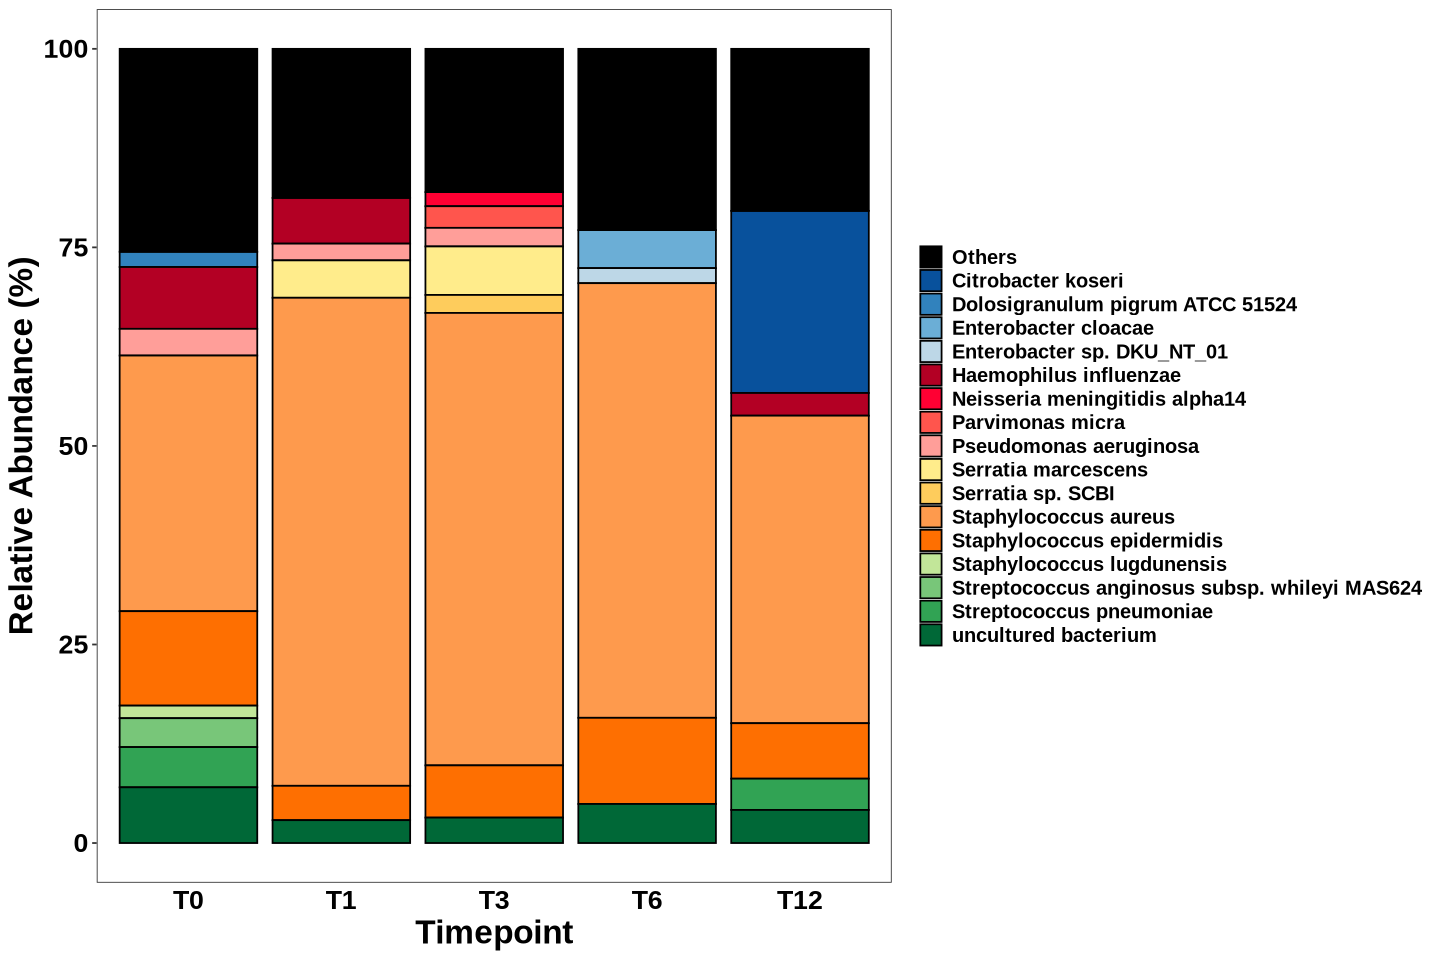

In [30]:
# Species-Level Relative Abundance Plot
# Aggregate counts at the species level
df_species <- aggregate(ReadCounts_TaxAnnotation$count, 
                       list(ReadCounts_TaxAnnotation$Species, ReadCounts_TaxAnnotation$ID_Sample, ReadCounts_TaxAnnotation$Timepoint), 
                       FUN=sum) 
colnames(df_species) <- c("Taxa", "ID_Sample", "Timepoint", "Counts")

# Create relative abundance data
cast_data_species = acast(df_species, Timepoint ~ Taxa, value.var = "Counts", fun.aggregate = sum)
cast_data_species[is.na(cast_data_species)] <- 0 # Replace missing values with 0

# Calculating relative abundance
tcast_data_species <- t(cast_data_species)
relative_abundance_species <- (t(tcast_data_species) / apply(tcast_data_species, 2, sum)) * 100
df_relab_species <- melt(relative_abundance_species) # Reshape data frame

# Rename columns
colnames(df_relab_species) <- c("Timepoint", "Taxa", "RelativeAbundance") 
df_relab_species <- df_relab_species[-which(df_relab_species$RelativeAbundance == 0),] # Remove rows with zero relative abundance

# Filter taxa above threshold (1.5%)
df_relab_species_filt <- subset(df_relab_species, RelativeAbundance > 1.5)

# Compute "Others"
df_sum <- df_relab_species_filt %>%
    group_by(Timepoint) %>%
    summarise(TotalAbundance = sum(RelativeAbundance))

df_others <- df_sum %>%
    mutate(Taxa = "Others", RelativeAbundance = 100 - TotalAbundance) %>%
    select(Timepoint, Taxa, RelativeAbundance)

df_relab_species_filt <- bind_rows(df_relab_species_filt, df_others)

# Order factors
df_relab_species_filt$Timepoint <- factor(df_relab_species_filt$Timepoint, levels = c("T0", "T1", "T3", "T6", "T12"))

df_relab_species_filt <- df_relab_species_filt %>%
  mutate(Taxa = factor(Taxa, levels = c(setdiff(unique(Taxa), "Others"), "Others")))

# Define custom color palette
purples <- brewer.pal(n = 5, name = "BuPu")[-c(1:4)]
blues <- rev(brewer.pal(n = 5, name = "Blues")[-1])
greens <- brewer.pal(n = 5, name = "YlGn")[-1]
oranges <- c("#FFEC8B", "#FECC5C", "#fe9a4d", "#fe6f01")
reds <- c("#b30024", "#ff0033", "#ff554d", "#ff9e99")
purples <- append(purples, c("#ac39ac", "#cc66cc", "#ffb3ff"))
beiges <- c("#999966", "#adad85", "#ccccb3")
aquamarines <- c("#25a696", "#43d6c5", "#96e8df")
pinks <- c("#9F2B68", "#F33A6A")
gray <- c("#808080")
custom_colors <- c(blues, reds, oranges, greens, purples, rev(beiges), aquamarines, pinks)

# Assign colors to taxa
unique_taxa <- setdiff(unique(df_relab_species_filt$Taxa), "Others")
color_palette <- setNames(custom_colors[seq_along(unique_taxa)], unique_taxa)
color_palette["Others"] <- "black"

# Plot
species_plot <- ggplot(data = df_relab_species_filt, 
                      aes(x = Timepoint, y = RelativeAbundance, 
                          fill = factor(Taxa, levels = c("Others", setdiff(unique(df_relab_species_filt$Taxa), "Others"))))) + 
    geom_bar(stat = "identity", position = "stack", colour = "black") +
    scale_fill_manual(values = color_palette) + 
    labs(x = "Timepoint", y = "Relative Abundance (%)") +
    theme_bw() +
    theme(axis.title.x = element_text(size = 20, face = "bold", color = "black"),
          axis.text.x = element_text(size = 16, face = "bold", color = "black"),
          axis.title.y = element_text(size = 20, face = "bold", color = "black"),
          axis.text.y = element_text(size = 16, face = "bold", color = "black"),
          strip.text.x = element_text(size = 16, face = "bold", color = "black"),
          legend.title = element_blank(),
          legend.text = element_text(size = 12, face = "bold"),
          axis.ticks.x = element_blank(),
          strip.background = element_rect(fill = "white"),
          panel.grid = element_blank(),
          legend.position = "right") +
    theme(legend.key.size = unit(0.5, "cm")) + # adjust legend key size
    guides(fill = guide_legend(ncol = 1))  # Force legend into one column
species_plot

In [31]:
# Species-Level Relative Abundance Plot: Staphyloccoci

## Filter to only Staphylococcus species
staph_species_data <- ReadCounts_TaxAnnotation %>%
  filter(grepl("^Staphylococcus", Species))
print(head(staph_species_data))

    ID_Sample           id count  Kingdom    Phylum   Class            Order
1 0001967K_T1     AB646616     1 Bacteria Bacillota Bacilli Staphylococcales
2 0001967K_T1     AF015929     4 Bacteria Bacillota Bacilli Staphylococcales
3 0001967K_T1 AIYD01000002     2 Bacteria Bacillota Bacilli Staphylococcales
4 0001967K_T1     AJ938182     1 Bacteria Bacillota Bacilli Staphylococcales
5 0001967K_T1     AJ938182     1 Bacteria Bacillota Bacilli Staphylococcales
6 0001967K_T1     AJ938182     1 Bacteria Bacillota Bacilli Staphylococcales
             Family          Genus                        Species total_aligned
1 Staphylococcaceae Staphylococcus Staphylococcus saccharolyticus           670
2 Staphylococcaceae Staphylococcus          Staphylococcus aureus           670
3 Staphylococcaceae Staphylococcus    Staphylococcus aureus M1016           670
4 Staphylococcaceae Staphylococcus    Staphylococcus aureus RF122           670
5 Staphylococcaceae Staphylococcus    Staphylococcus aureus R

Warning message:
“Use of `df_relab_staph_filt$Taxa` is discouraged.
ℹ Use `Taxa` instead.”


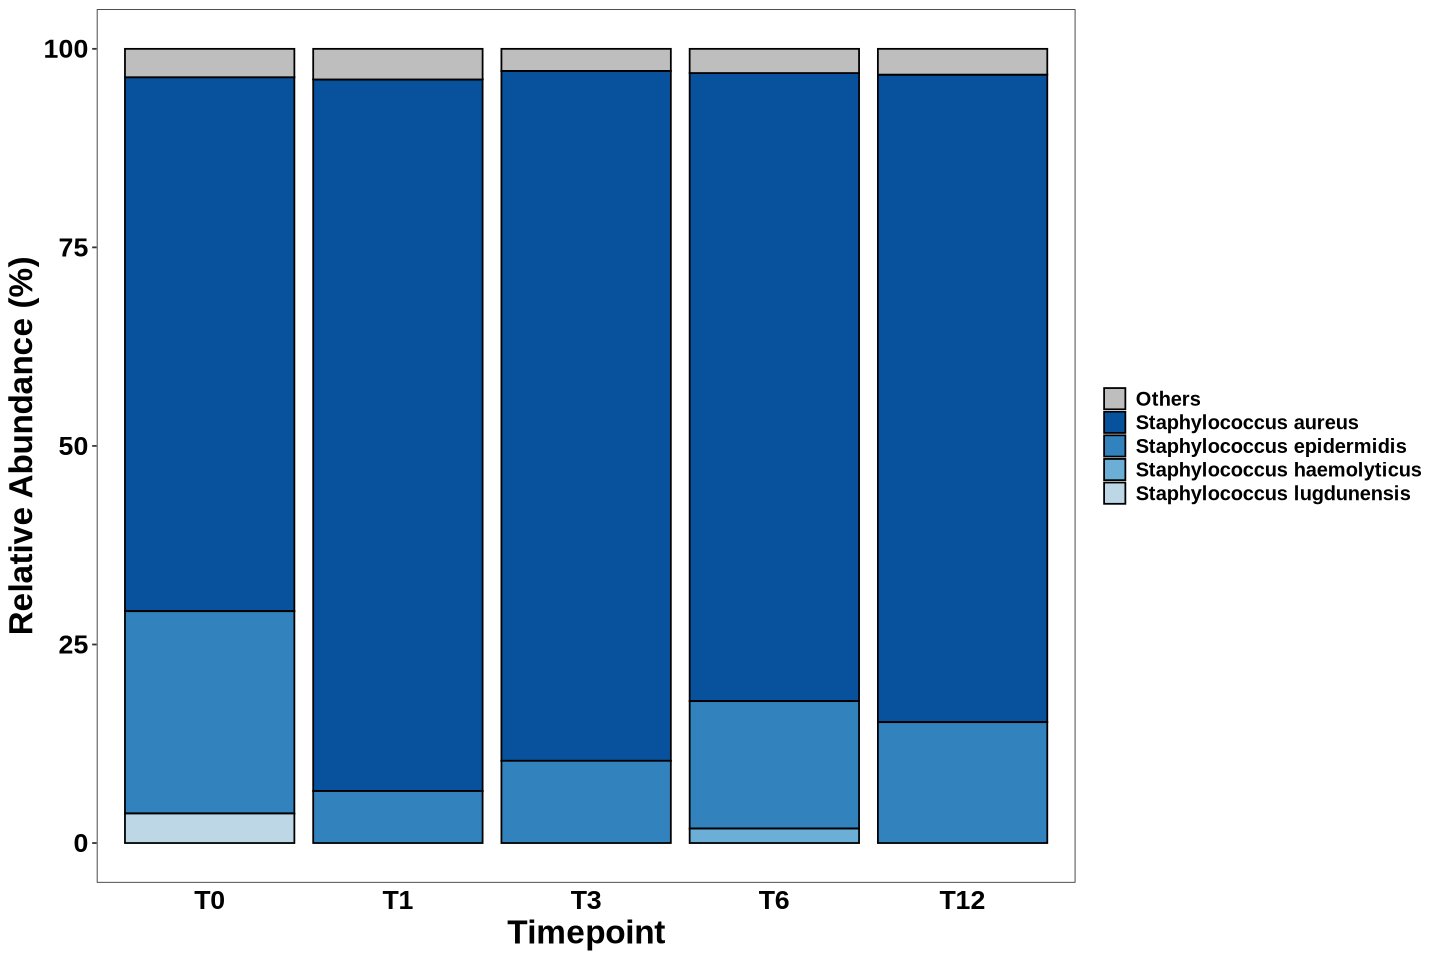

In [32]:
## Collapse species lineages to genus + species (first two words)
staph_species_data$Collapsed_Species <- gsub("^([A-Za-z]+\\s+[a-z]+).*", "\\1", staph_species_data$Species)

## Aggregate counts at the species level
df_species_staph <- aggregate(staph_species_data$count, 
                              list(staph_species_data$Collapsed_Species,
                                   staph_species_data$ID_Sample,
                                   staph_species_data$Timepoint), 
                              FUN = sum)
colnames(df_species_staph) <- c("Taxa", "ID_Sample", "Timepoint", "Counts")

## Create relative abundance data
cast_data_staph = acast(df_species_staph, Timepoint ~ Taxa, value.var = "Counts", fun.aggregate = sum)
cast_data_staph[is.na(cast_data_staph)] <- 0

## Calculate relative abundance
tcast_data_staph <- t(cast_data_staph)
relative_abundance_staph <- (t(tcast_data_staph) / apply(tcast_data_staph, 2, sum)) * 100
df_relab_staph <- melt(relative_abundance_staph)

colnames(df_relab_staph) <- c("Timepoint", "Taxa", "RelativeAbundance")
df_relab_staph <- df_relab_staph[df_relab_staph$RelativeAbundance > 0, ]

## Optional: Filter taxa above a threshold (e.g., 1.5%)
df_relab_staph_filt <- subset(df_relab_staph, RelativeAbundance > 1.5)

## Compute "Others"
df_sum_staph <- df_relab_staph_filt %>%
  group_by(Timepoint) %>%
  summarise(TotalAbundance = sum(RelativeAbundance))

df_others_staph <- df_sum_staph %>%
  mutate(Taxa = "Others", RelativeAbundance = 100 - TotalAbundance) %>%
  select(Timepoint, Taxa, RelativeAbundance)

df_relab_staph_filt <- bind_rows(df_relab_staph_filt, df_others_staph)

## Set factor levels
df_relab_staph_filt$Timepoint <- factor(df_relab_staph_filt$Timepoint, levels = c("T0", "T1", "T3", "T6", "T12"))
df_relab_staph_filt <- df_relab_staph_filt %>%
  mutate(Taxa = factor(Taxa, levels = c(setdiff(unique(Taxa), "Others"), "Others")))

## Assign colors
unique_taxa_staph <- setdiff(unique(df_relab_staph_filt$Taxa), "Others")
color_palette_staph <- setNames(custom_colors[seq_along(unique_taxa_staph)], unique_taxa_staph)
color_palette_staph["Others"] <- "gray"

## Plot
staph_plot <- ggplot(data = df_relab_staph_filt, 
                     aes(x = Timepoint, y = RelativeAbundance, 
                         fill = factor(Taxa, levels = c("Others", setdiff(unique(df_relab_staph_filt$Taxa), "Others"))))) + 
  geom_bar(stat = "identity", position = "stack", colour = "black") +
  scale_fill_manual(values = color_palette_staph) + 
  labs(x = "Timepoint", y = "Relative Abundance (%)") +
  theme_bw() +
  theme(axis.title.x = element_text(size = 20, face = "bold", color = "black"),
        axis.text.x = element_text(size = 16, face = "bold", color = "black"),
        axis.title.y = element_text(size = 20, face = "bold", color = "black"),
        axis.text.y = element_text(size = 16, face = "bold", color = "black"),
        strip.text.x = element_text(size = 16, face = "bold", color = "black"),
        legend.title = element_blank(),
        legend.text = element_text(size = 12, face = "bold"),
        axis.ticks.x = element_blank(),
        strip.background = element_rect(fill = "white"),
        panel.grid = element_blank(),
        legend.position = "right") +
  theme(legend.key.size = unit(0.5, "cm")) +
  guides(fill = guide_legend(ncol = 1)) 

staph_plot

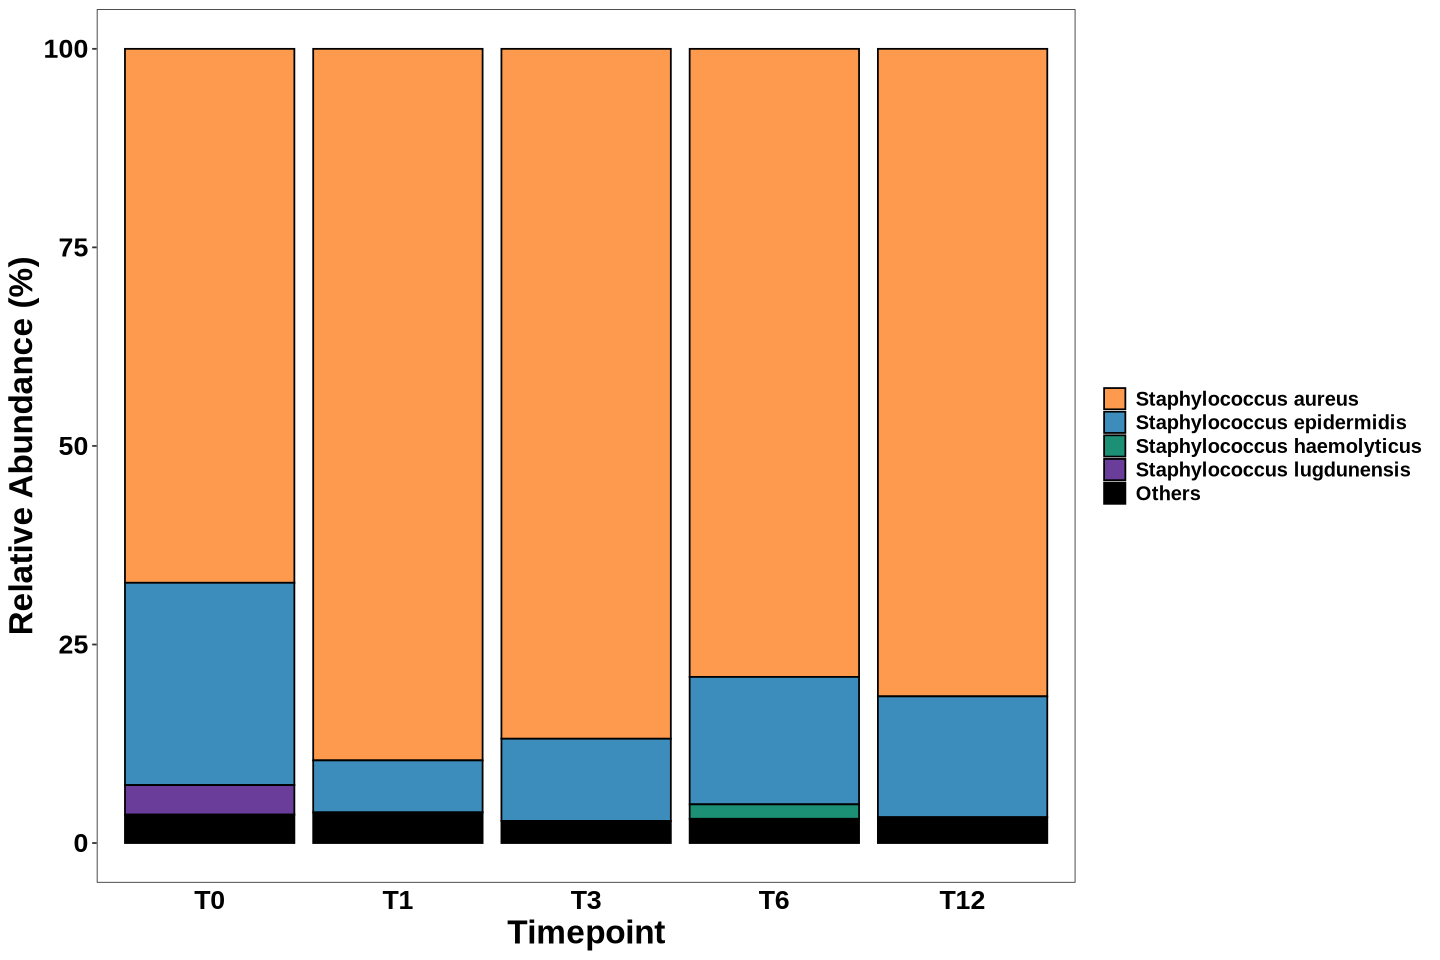

In [33]:
# Make the same Staphylococcus plot, but using shades of the same color for differenciating between CoPS and CoNS
## Define your groups
cop_species <- c("Staphylococcus aureus") #, "Staphylococcus argenteus", "Staphylococcus roterodami", "Staphylococcus schweitzeri")
cons_species <- c("Staphylococcus epidermidis", "Staphylococcus lugdunensis", "Staphylococcus haemolyticus")

# Color palettes
cop_colors <- c("#fe9a4d")
cons_colors <- c("#3C8DBC", "#6A3D9A", "#1C9075")

# Filter taxa (excluding "Others") for coloring
taxa_to_color <- setdiff(unique(df_relab_staph_filt$Taxa), "Others")

# Create named color vector
color_palette_staph <- sapply(taxa_to_color, function(taxa) {
  if (taxa %in% cop_species) {
    return(cop_colors[which(cop_species == taxa)])
  } else if (taxa %in% cons_species) {
    return(cons_colors[which(cons_species == taxa)])
  } else {
    return("#999999") # fallback for unknown taxa
  }
})
color_palette_staph["Others"] <- "black"

df_relab_staph_filt <- df_relab_staph_filt %>%
  mutate(Taxa = factor(Taxa, levels = c(setdiff(unique(Taxa), "Others"), "Others")))

staph_plot <- ggplot(data = df_relab_staph_filt, 
                     aes(x = Timepoint, y = RelativeAbundance, fill = Taxa)) + 
  geom_bar(stat = "identity", position = "stack", colour = "black") +
  scale_fill_manual(values = color_palette_staph) +
  labs(x = "Timepoint", y = "Relative Abundance (%)") +
  theme_bw() +
  theme(axis.title.x = element_text(size = 20, face = "bold", color = "black"),
        axis.text.x = element_text(size = 16, face = "bold", color = "black"),
        axis.title.y = element_text(size = 20, face = "bold", color = "black"),
        axis.text.y = element_text(size = 16, face = "bold", color = "black"),
        strip.text.x = element_text(size = 16, face = "bold", color = "black"),
        legend.title = element_blank(),
        legend.text = element_text(size = 12, face = "bold"),
        axis.ticks.x = element_blank(),
        strip.background = element_rect(fill = "white"),
        panel.grid = element_blank(),
        legend.position = "right") +
  theme(legend.key.size = unit(0.5, "cm")) +
  guides(fill = guide_legend(ncol = 1))

options(repr.plot.width = 12, repr.plot.height = 8)

staph_plot

In [59]:
ggsave("staphspp_plot_relabund.png", plot = staph_plot, width = 10, height = 6, dpi = 300)

In [60]:
print(head(df_relab_staph_filt))

  Timepoint                       Taxa RelativeAbundance
1        T0      Staphylococcus aureus          67.23164
2        T1      Staphylococcus aureus          89.59701
3       T12      Staphylococcus aureus          81.53459
4        T3      Staphylococcus aureus          86.86858
5        T6      Staphylococcus aureus          79.08337
6        T0 Staphylococcus epidermidis          25.47533


In [61]:
write.table(df_relab_staph_filt, file = "df_relab_staph_filt.tsv", quote = FALSE, sep = "\t", row.names = F)

In [34]:
# Plot changes in the relative abundance of specific genus across timepoints
#### Staphylococcus

## Ensure ordered timepoints
df_species$Timepoint <- factor(df_species$Timepoint, levels = c("T0", "T1", "T3", "T6", "T12"))

## Extract only the Genus (first word of Taxa)
df_species <- df_species %>%
  mutate(Genus = word(Taxa, 1))  # or: str_extract(Taxa, "^\\S+")

## Recalculate relative abundance per sample (based on original Counts)
df_species <- df_species %>%
  group_by(ID_Sample) %>%
  mutate(RelAbund = Counts / sum(Counts) * 100) %>%
  ungroup()

head(df_species)

## Filter for Genus: Staphylococcus
df_staph <- df_species %>%
  filter(Genus == "Staphylococcus")
head(df_staph) 

## Sum relative abundance per sample across all Staph species
df_staph_genus <- df_staph %>%
  group_by(ID_Sample, Timepoint) %>%
  summarise(RelAbund = sum(RelAbund), .groups = "drop")
head(df_staph_genus) 

## Compute timepoint-wise mean
means_staph <- df_staph_genus %>%
  group_by(Timepoint) %>%
  summarise(Mean = mean(RelAbund), .groups = "drop")

## Define pairwise comparisons
my_comparisons <- list(
  c("T0", "T1"), c("T0", "T3"), c("T0", "T6"), c("T0", "T12"),
  c("T1", "T3"), c("T1", "T6"), c("T1", "T12"),
  c("T3", "T6"), c("T3", "T12"),
  c("T6", "T12")
)

Taxa,ID_Sample,Timepoint,Counts,Genus,RelAbund
<chr>,<chr>,<fct>,<int>,<chr>,<dbl>
[Propionibacterium] namnetense,0088303G_T0,T0,1,[Propionibacterium],0.01600512
Anaerococcus octavius,0088303G_T0,T0,4,Anaerococcus,0.06402049
bacterium,0088303G_T0,T0,8,bacterium,0.12804097
bacterium 1-gw1-3,0088303G_T0,T0,9,bacterium,0.14404609
bacterium HKG213,0088303G_T0,T0,16,bacterium,0.25608195
bacterium N47,0088303G_T0,T0,21,bacterium,0.33610755


Taxa,ID_Sample,Timepoint,Counts,Genus,RelAbund
<chr>,<chr>,<fct>,<int>,<chr>,<dbl>
Staphylococcus aureus,0088303G_T0,T0,105,Staphylococcus,1.68053777
Staphylococcus aureus subsp. anaerobius,0088303G_T0,T0,1,Staphylococcus,0.01600512
Staphylococcus aureus subsp. aureus Tager 104,0088303G_T0,T0,7,Staphylococcus,0.11203585
Staphylococcus capitis,0088303G_T0,T0,216,Staphylococcus,3.45710627
Staphylococcus capitis subsp. urealyticus,0088303G_T0,T0,2,Staphylococcus,0.03201024
Staphylococcus caprae,0088303G_T0,T0,26,Staphylococcus,0.41613316


ID_Sample,Timepoint,RelAbund
<chr>,<fct>,<dbl>
0001967K_T1,T1,96.63290
0001967K_T3,T3,98.38821
0001967K_T6,T6,98.81448
0088303G_T0,T0,62.82010
0088303G_T1,T1,98.49397
0088303G_T3,T3,79.26682


In [18]:
# Get stats computed in the plot below 
## Define comparisons you want, e.g., pairs of timepoints
my_comparisons <- list(
  c("T0", "T1"), c("T0", "T3"), c("T0", "T6"), c("T0", "T12"),
  c("T1", "T3"), c("T1", "T6"), c("T1", "T12"),
  c("T3", "T6"), c("T3", "T12"),
  c("T6", "T12")
)

## Run pairwise Wilcoxon tests for RelAbund across Timepoints
test_results <- ReadCounts_TaxAnnotation %>%
  wilcox_test(RelAbund ~ Timepoint) %>%
  adjust_pvalue(method = "bonferroni") %>%
  add_significance()

print(test_results)

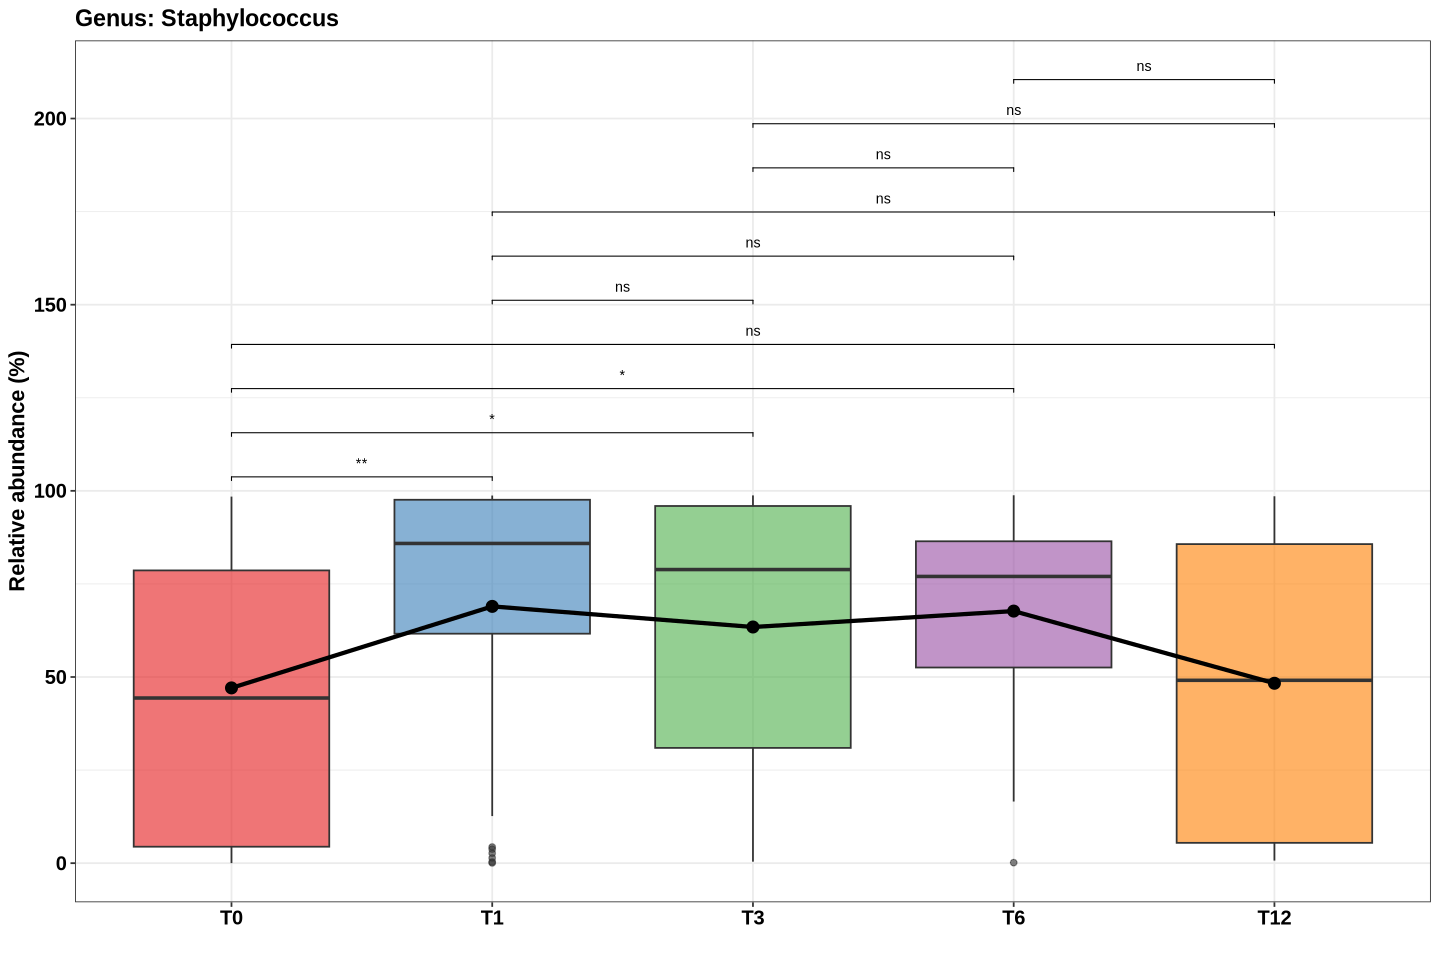

In [35]:
## Plot Staphylococcus spp.
p_staph_genus <- ggplot(df_staph_genus, aes(x = Timepoint, y = RelAbund)) +
  geom_boxplot(aes(fill = Timepoint), alpha = 0.6) +
  stat_summary(fun = mean, geom = "point", shape = 21, size = 3, fill = "black") +
  geom_line(data = means_staph, aes(x = Timepoint, y = Mean, group = 1), color = "black", linewidth = 1.2) +
  geom_point(data = means_staph, aes(x = Timepoint, y = Mean), color = "black", size = 2.5) +
  stat_compare_means(
    comparisons = my_comparisons,
    method = "wilcox.test",
    p.adjust.method = "bonferroni",
    label = "p.signif",
    tip.length = 0.01,
    size = 3
  ) +
  theme_bw() +
  labs(
    title = "Genus: Staphylococcus",
    y = "Relative abundance (%)",
    x = ""
  ) +
  scale_fill_brewer(palette = "Set1") +
  theme(
    plot.title = element_text(size = 14, face = "bold"),
    axis.title.y = element_text(size = 13, face = "bold"),
    axis.text.y = element_text(size = 12, face = "bold", color = "black"),
    axis.text.x = element_text(size = 12, face = "bold", color = "black"),
    strip.text = element_text(face = "bold"),
    legend.title = element_text(face = "bold"),
    legend.text = element_text(face = "bold"),
    legend.position = "none"
  )

p_staph_genus

In [36]:
df_staph_genus$Genus <- "Staphylococcus spp."
means_staph$Genus <- "Staphylococcus spp."

head(df_staph_genus)

ID_Sample,Timepoint,RelAbund,Genus
<chr>,<fct>,<dbl>,<chr>
0001967K_T1,T1,96.63290,Staphylococcus spp.
0001967K_T3,T3,98.38821,Staphylococcus spp.
0001967K_T6,T6,98.81448,Staphylococcus spp.
0088303G_T0,T0,62.82010,Staphylococcus spp.
0088303G_T1,T1,98.49397,Staphylococcus spp.
0088303G_T3,T3,79.26682,Staphylococcus spp.


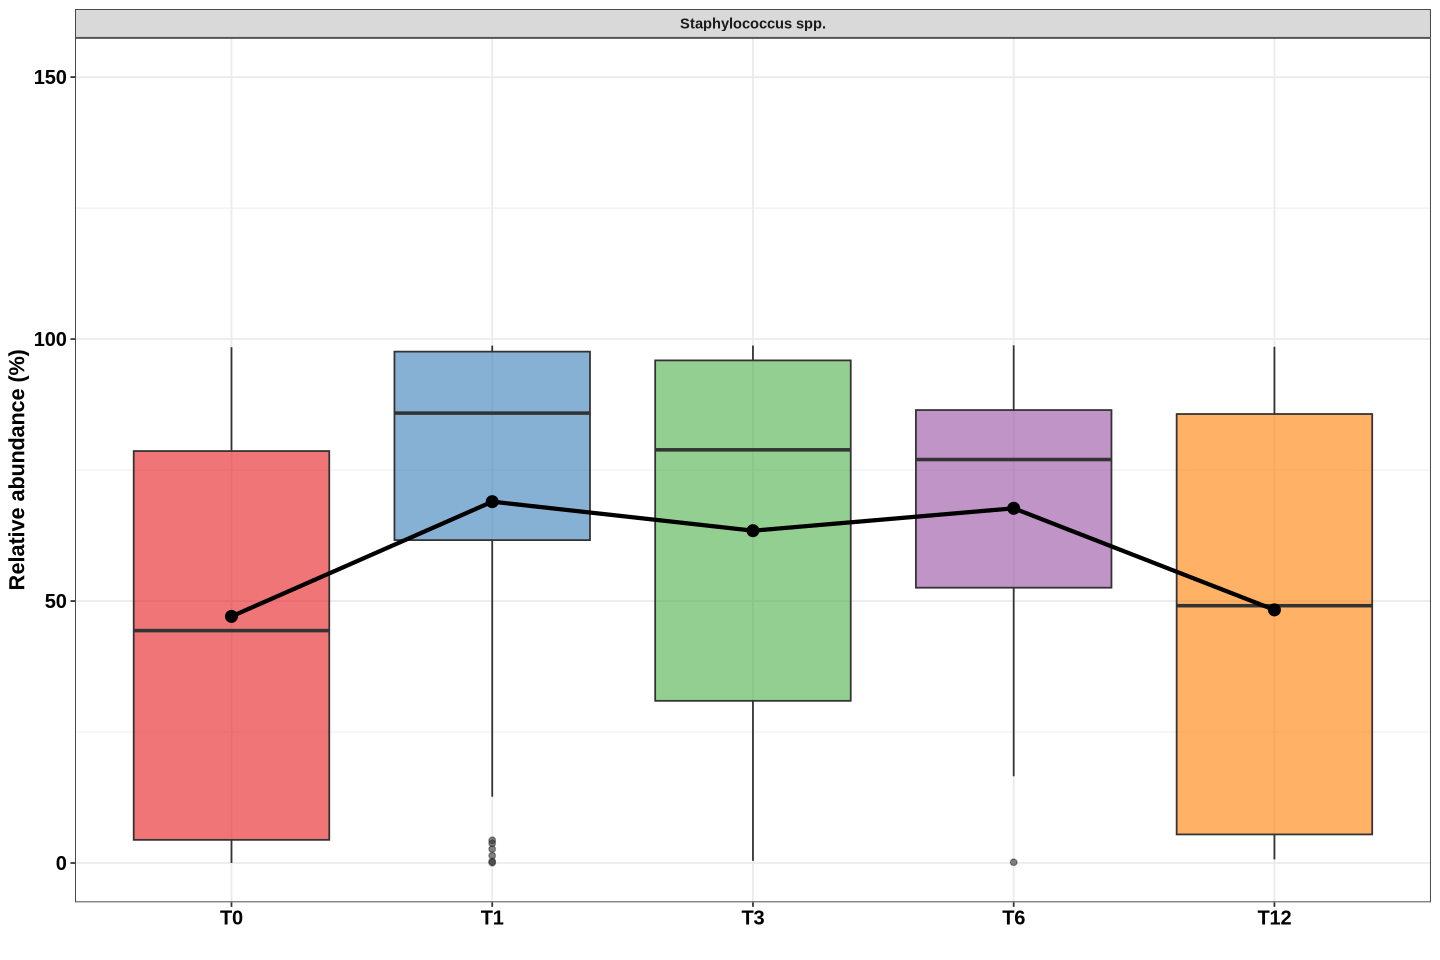

In [37]:
## Plot Staphylococcus spp. without comparison bars
p_staph_genus <- ggplot(df_staph_genus, aes(x = Timepoint, y = RelAbund)) +
  geom_boxplot(aes(fill = Timepoint), alpha = 0.6) +
  stat_summary(fun = mean, geom = "point", shape = 21, size = 3, fill = "black") +
  geom_line(data = means_staph, aes(x = Timepoint, y = Mean, group = 1), color = "black", linewidth = 1.2) +
  geom_point(data = means_staph, aes(x = Timepoint, y = Mean), color = "black", size = 2.5) +
  theme_bw() +
  labs(
    y = "Relative abundance (%)",
    x = ""
  ) +
  scale_fill_brewer(palette = "Set1") +
  scale_y_continuous(limits = c(0, 150)) +  #  extends the y-axis
  facet_wrap(~ Genus) +  # adds the top label
  theme(
    plot.title = element_text(size = 14, face = "italic"),
    axis.title.y = element_text(size = 13, face = "bold"),
    axis.text.y = element_text(size = 12, face = "bold", color = "black"),
    axis.text.x = element_text(size = 12, face = "bold", color = "black"),
    strip.text = element_text(face = "bold"),
    legend.title = element_text(face = "bold"),
    legend.text = element_text(face = "bold"),
    legend.position = "none"
  )

p_staph_genus

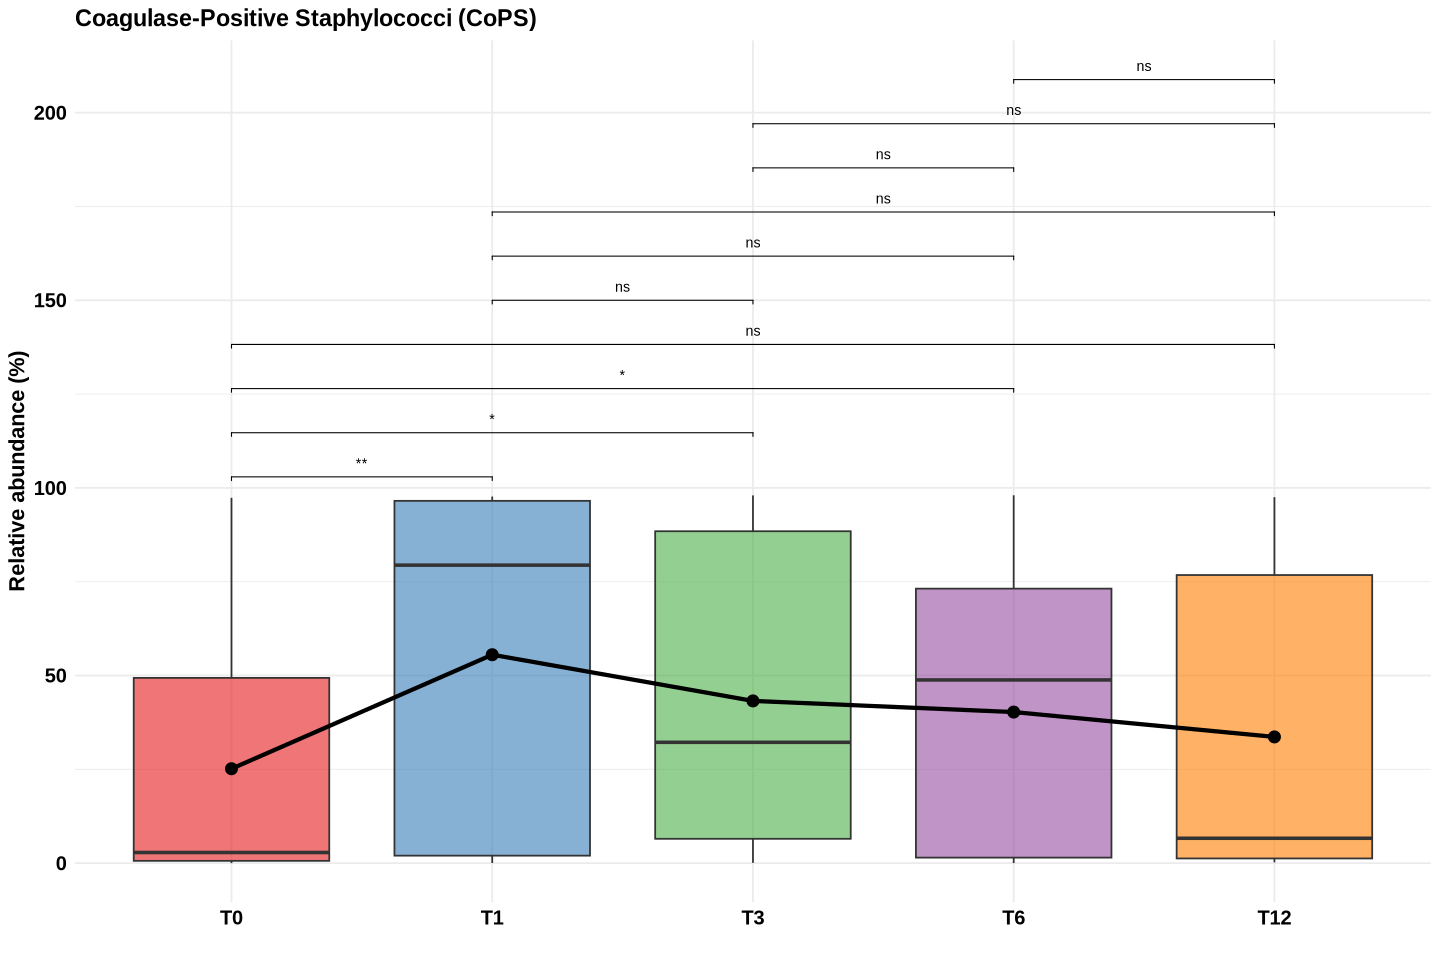

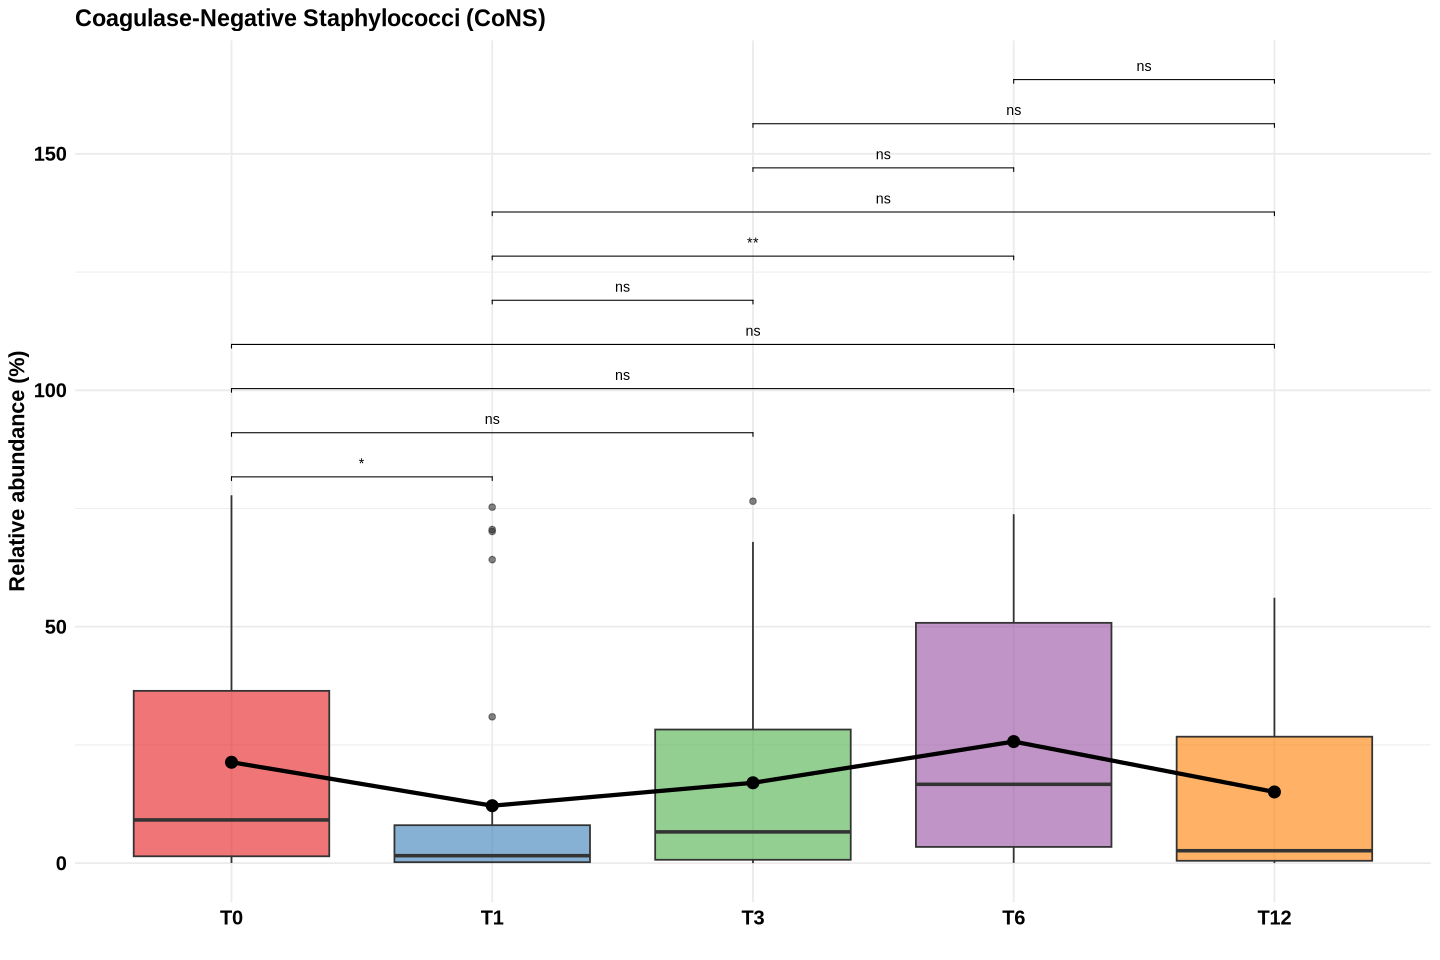

In [38]:
#### CoPS x CoNS
## Extract Genus + species (first two words from Taxa)
df_species <- df_species %>%
  mutate(Taxa_clean = str_extract(Taxa, "^\\S+\\s+\\S+"))

## Recalculate relative abundance per sample
df_species <- df_species %>%
  group_by(ID_Sample) %>%
  mutate(RelAbund = Counts / sum(Counts) * 100) %>%
  ungroup()

## Define species groups
cop_species <- c("Staphylococcus aureus")
cons_species <- c("Staphylococcus epidermidis", "Staphylococcus lugdunensis", "Staphylococcus haemolyticus")

### ---- CoP Staphylococcus Plot ---- ###
df_cop <- df_species %>%
  filter(Taxa_clean %in% cop_species) %>%
  group_by(ID_Sample, Timepoint) %>%
  summarise(RelAbund = sum(RelAbund), .groups = "drop")

means_cop <- df_cop %>%
  group_by(Timepoint) %>%
  summarise(Mean = mean(RelAbund), .groups = "drop")

p_cop <- ggplot(df_cop, aes(x = Timepoint, y = RelAbund)) +
  geom_boxplot(aes(fill = Timepoint), alpha = 0.6) +
  stat_summary(fun = mean, geom = "point", shape = 21, size = 3, fill = "black") +
  geom_line(data = means_cop, aes(x = Timepoint, y = Mean, group = 1), color = "black", linewidth = 1.2) +
  geom_point(data = means_cop, aes(x = Timepoint, y = Mean), color = "black", size = 2.5) +
  stat_compare_means(
    comparisons = my_comparisons,
    method = "wilcox.test",
    p.adjust.method = "bonferroni",
    label = "p.signif",
    tip.length = 0.01,
    size = 3
  ) +
  theme_minimal() +
  labs(
    title = "Coagulase-Positive Staphylococci (CoPS)",
    y = "Relative abundance (%)",
    x = ""
  ) +
  scale_fill_brewer(palette = "Set1") +
  theme(
    plot.title = element_text(size = 14, face = "bold"),
    axis.title.y = element_text(size = 13, face = "bold"),
    axis.text = element_text(size = 12, face = "bold", color = "black"),
    legend.position = "none"
  )


### ---- CoNS Staphylococcus Plot ---- ###
df_cons <- df_species %>%
  filter(Taxa_clean %in% cons_species) %>%
  group_by(ID_Sample, Timepoint) %>%
  summarise(RelAbund = sum(RelAbund), .groups = "drop")

means_cons <- df_cons %>%
  group_by(Timepoint) %>%
  summarise(Mean = mean(RelAbund), .groups = "drop")

p_cons <- ggplot(df_cons, aes(x = Timepoint, y = RelAbund)) +
  geom_boxplot(aes(fill = Timepoint), alpha = 0.6) +
  stat_summary(fun = mean, geom = "point", shape = 21, size = 3, fill = "black") +
  geom_line(data = means_cons, aes(x = Timepoint, y = Mean, group = 1), color = "black", linewidth = 1.2) +
  geom_point(data = means_cons, aes(x = Timepoint, y = Mean), color = "black", size = 2.5) +
  stat_compare_means(
    comparisons = my_comparisons,
    method = "wilcox.test",
    p.adjust.method = "bonferroni",
    label = "p.signif",
    tip.length = 0.01,
    size = 3
  ) +
  theme_minimal() +
  labs(
    title = "Coagulase-Negative Staphylococci (CoNS)",
    y = "Relative abundance (%)",
    x = ""
  ) +
  scale_fill_brewer(palette = "Set1") +
  theme(
    plot.title = element_text(size = 14, face = "bold"),
    axis.title.y = element_text(size = 13, face = "bold"),
    axis.text = element_text(size = 12, face = "bold", color = "black"),
    legend.position = "none"
  )

# Show both plots
p_cop
p_cons


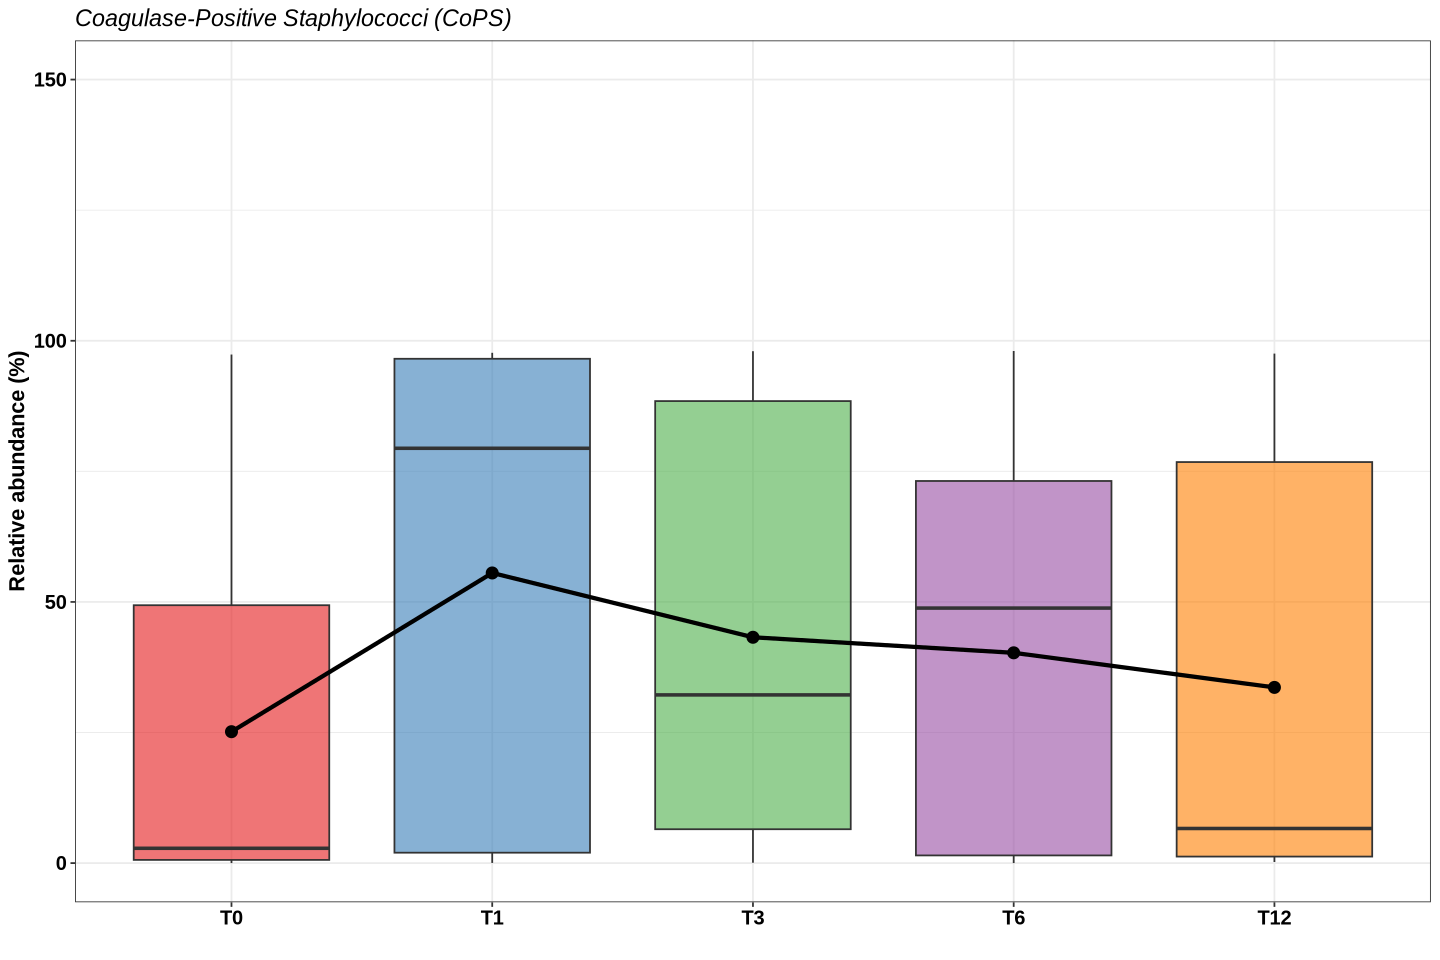

In [39]:
p_cop <- ggplot(df_cop, aes(x = Timepoint, y = RelAbund)) +
  geom_boxplot(aes(fill = Timepoint), alpha = 0.6) +
  stat_summary(fun = mean, geom = "point", shape = 21, size = 3, fill = "black") +
  geom_line(data = means_cop, aes(x = Timepoint, y = Mean, group = 1), color = "black", linewidth = 1.2) +
  geom_point(data = means_cop, aes(x = Timepoint, y = Mean), color = "black", size = 2.5) +
  theme_bw() +
  labs(
    title = "Coagulase-Positive Staphylococci (CoPS)",
    y = "Relative abundance (%)",
    x = ""
  ) +
  scale_fill_brewer(palette = "Set1") +
  scale_y_continuous(limits = c(0, 150)) +  # extends the y-axis
  theme(
    plot.title = element_text(size = 14, face = "italic"),
    axis.title.y = element_text(size = 13, face = "bold"),
    axis.text = element_text(size = 12, face = "bold", color = "black"),
    legend.position = "none"
  )
p_cop

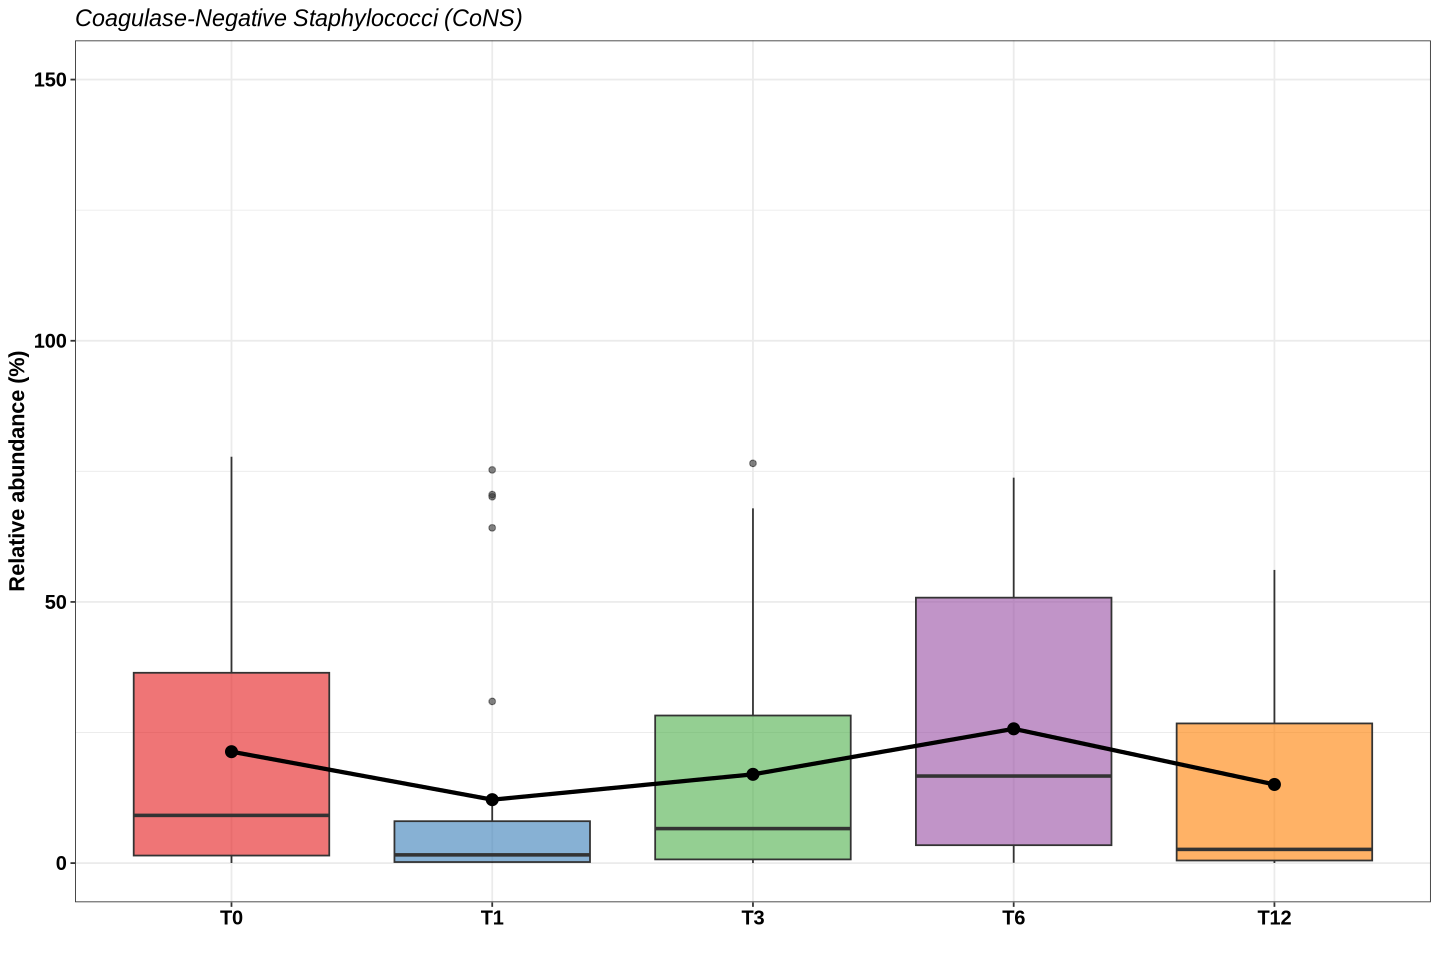

In [40]:
p_cons <- ggplot(df_cons, aes(x = Timepoint, y = RelAbund)) +
  geom_boxplot(aes(fill = Timepoint), alpha = 0.6) +
  stat_summary(fun = mean, geom = "point", shape = 21, size = 3, fill = "black") +
  geom_line(data = means_cons, aes(x = Timepoint, y = Mean, group = 1), color = "black", linewidth = 1.2) +
  geom_point(data = means_cons, aes(x = Timepoint, y = Mean), color = "black", size = 2.5) +
  theme_bw() +
  labs(
    title = "Coagulase-Negative Staphylococci (CoNS)",
    y = "Relative abundance (%)",
    x = ""
  ) +
  scale_fill_brewer(palette = "Set1") +
  scale_y_continuous(limits = c(0, 150)) +  # extends the y-axis
  theme(
    plot.title = element_text(size = 14, face = "italic"),
    axis.title.y = element_text(size = 13, face = "bold"),
    axis.text = element_text(size = 12, face = "bold", color = "black"),
    legend.position = "none"
  )
p_cons

In [41]:
df_cop$Group <- "CoPS"
df_cons$Group <- "CoNS"

df_combined <- rbind(df_cop, df_cons)
means_combined <- rbind(means_cop %>% mutate(Group = "CoPS"),
                        means_cons %>% mutate(Group = "CoNS"))

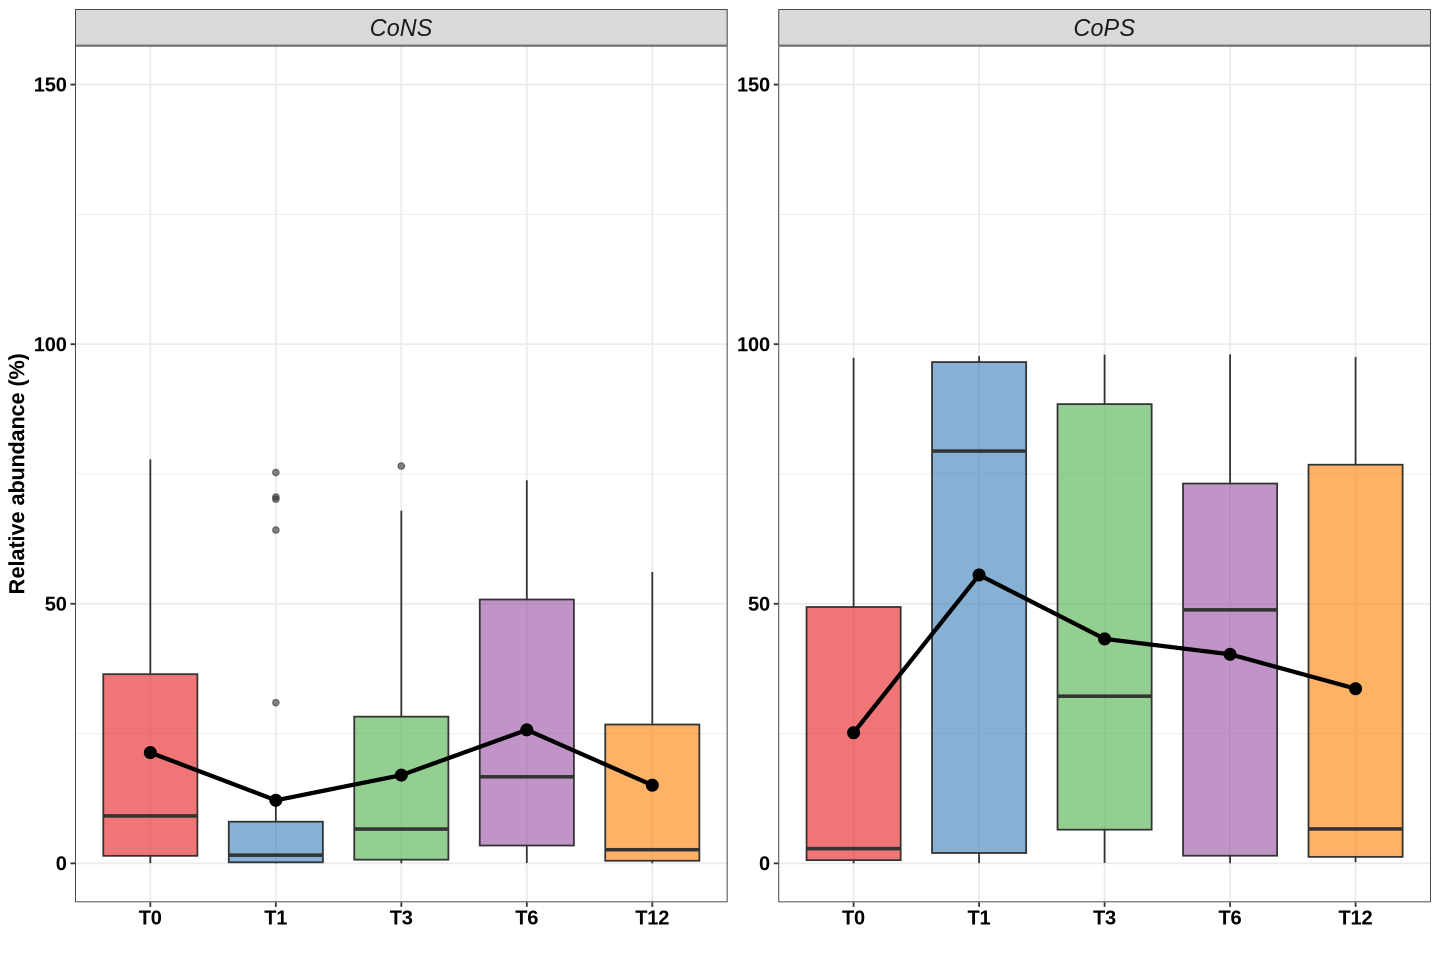

In [42]:
p_combined_staph <- ggplot(df_combined, aes(x = Timepoint, y = RelAbund)) +
  geom_boxplot(aes(fill = Timepoint), alpha = 0.6) +
  stat_summary(fun = mean, geom = "point", shape = 21, size = 3, fill = "black") +
  geom_line(data = means_combined, aes(x = Timepoint, y = Mean, group = 1), 
            color = "black", linewidth = 1.2) +
  geom_point(data = means_combined, aes(x = Timepoint, y = Mean), 
             color = "black", size = 2.5) +
  facet_wrap(~ Group, ncol = 2, scales = "free_y") +
  theme_bw() +
  labs(
    y = "Relative abundance (%)",
    x = ""
  ) +
  scale_fill_brewer(palette = "Set1") +
  scale_y_continuous(limits = c(0, 150)) +  # extends the y-axis

  theme(
    strip.text = element_text(size = 14, face = "italic"),
    axis.title.y = element_text(size = 13, face = "bold"),
    axis.text = element_text(size = 12, face = "bold", color = "black"),
    plot.title = element_text(size = 14, face = "italic"),
    legend.position = "none"
  )
p_combined_staph

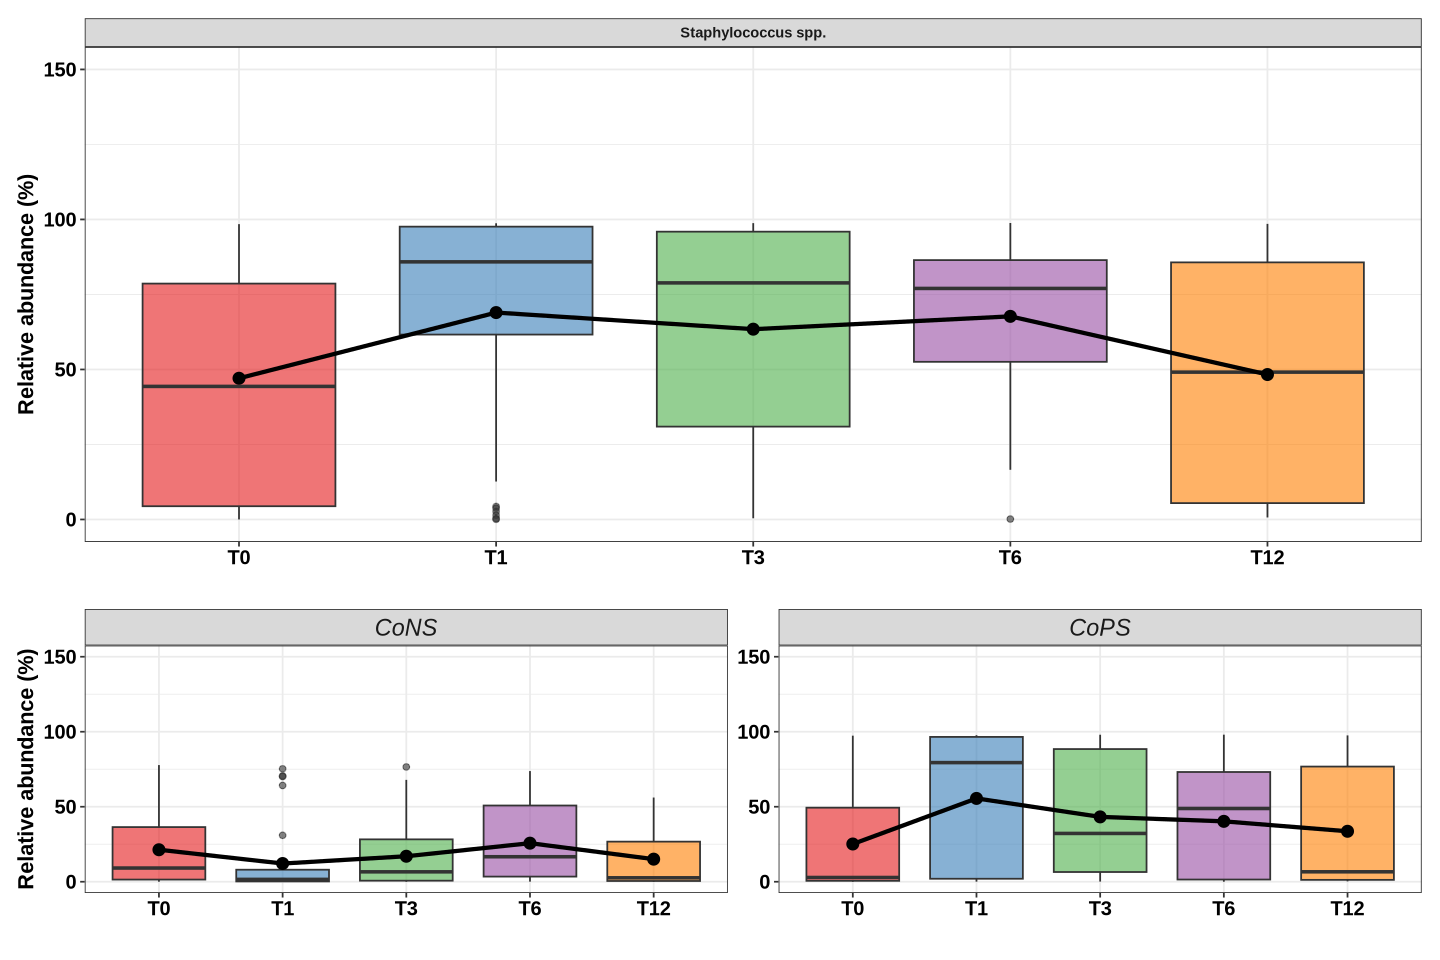

In [43]:
## Combine three plots in one
### Combine CoP and CoNS side-by-side
bottom_row <- p_combined_staph

### Stack the Staph plot on top and bottom row below, with relative heights
final_staph_plot <- p_staph_genus / bottom_row +
  plot_layout(heights = c(2, 1))  # 2:1 ratio (half vs quarter + quarter)

final_staph_plot

In [35]:
ggsave("final_staph_plotA.png", final_staph_plot, width = 12, height = 12, dpi = 300)

In [44]:
df_species[grep("Shigella", df_species$Taxa), ]

Taxa,ID_Sample,Timepoint,Counts,Genus,RelAbund,Taxa_clean
<chr>,<chr>,<fct>,<int>,<chr>,<dbl>,<chr>
Shigella dysenteriae,0130765A_T0,T0,7,Shigella,0.207530388,Shigella dysenteriae
Shigella flexneri,0130765A_T0,T0,7,Shigella,0.207530388,Shigella flexneri
Shigella boydii ATCC 9905,0236549G_T0,T0,1,Shigella,0.022172949,Shigella boydii
Shigella dysenteriae,0878122D_T0,T0,7,Shigella,0.033352392,Shigella dysenteriae
Shigella dysenteriae,1560534I_T0,T0,7,Shigella,0.041123252,Shigella dysenteriae
Shigella dysenteriae,1562839D_T0,T0,7,Shigella,0.085013359,Shigella dysenteriae
Shigella flexneri,1562839D_T0,T0,2,Shigella,0.024289531,Shigella flexneri
Shigella boydii,1272679D_T12,T12,14,Shigella,0.716112532,Shigella boydii
Shigella dysenteriae,1272679D_T12,T12,14,Shigella,0.716112532,Shigella dysenteriae


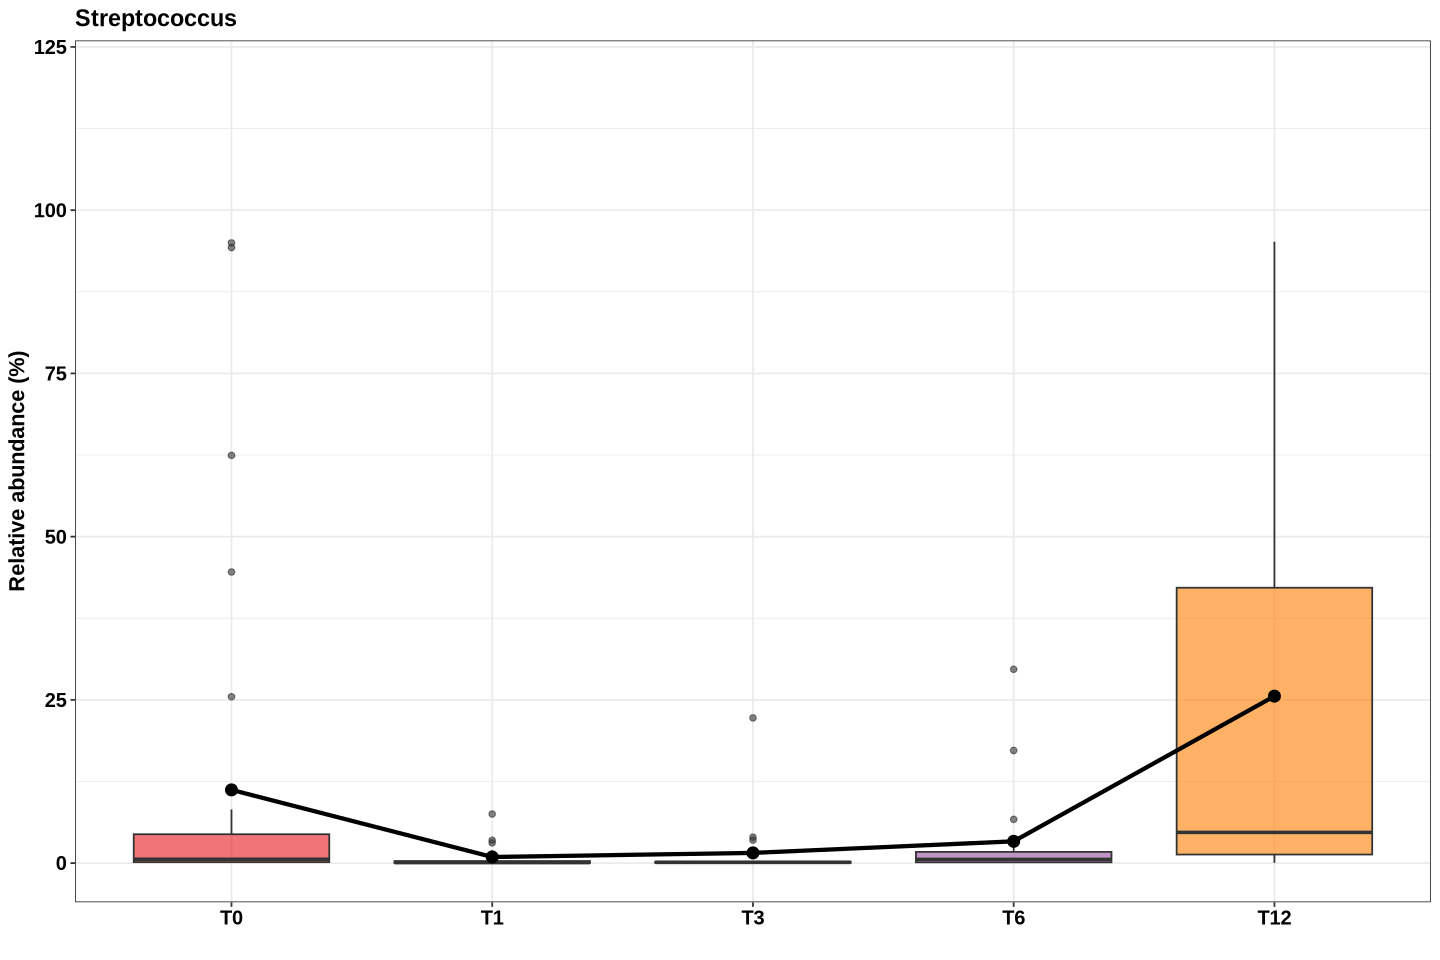

In [89]:
# Plot changes in the relative abundance of specific genus across timepoints
## Filter for Genus: Streptococcus
df_strepto <- df_species %>%
  filter(Genus == "Streptococcus")

## Sum relative abundance per sample across all Strepto species
df_strepto_genus <- df_strepto %>%
  group_by(ID_Sample, Timepoint) %>%
  summarise(RelAbund = sum(RelAbund), .groups = "drop")

## Compute timepoint-wise mean
means_strepto <- df_strepto_genus %>%
  group_by(Timepoint) %>%
  summarise(Mean = mean(RelAbund), .groups = "drop")

## Plot Streptococcus spp.
p_strepto_genus <- ggplot(df_strepto_genus, aes(x = Timepoint, y = RelAbund)) +
  geom_boxplot(aes(fill = Timepoint), alpha = 0.6) +
  stat_summary(fun = mean, geom = "point", shape = 21, size = 3, fill = "black") +
  geom_line(data = means_strepto, aes(x = Timepoint, y = Mean, group = 1), color = "black", linewidth = 1.2) +
  geom_point(data = means_strepto, aes(x = Timepoint, y = Mean), color = "black", size = 2.5) +
  # stat_compare_means(
  #   comparisons = my_comparisons,
  #   method = "wilcox.test",
  #   p.adjust.method = "bonferroni",
  #   label = "p.signif",
  #   tip.length = 0.01,
  #   size = 3
  # ) +
  theme_bw() +
  labs(
    title = "Streptococcus",
    y = "Relative abundance (%)",
    x = ""
  ) +
  scale_fill_brewer(palette = "Set1") +
  scale_y_continuous(limits = c(0, 120)) +  # extends the y-axis
  theme(
    plot.title = element_text(size = 14, face = "bold"),
    axis.title.y = element_text(size = 13, face = "bold"),
    axis.text.y = element_text(size = 12, face = "bold", color = "black"),
    axis.text.x = element_text(size = 12, face = "bold", color = "black"),
    strip.text = element_text(face = "bold"),
    legend.title = element_text(face = "bold"),
    legend.text = element_text(face = "bold"),
    legend.position = "none"
  )
p_strepto_genus

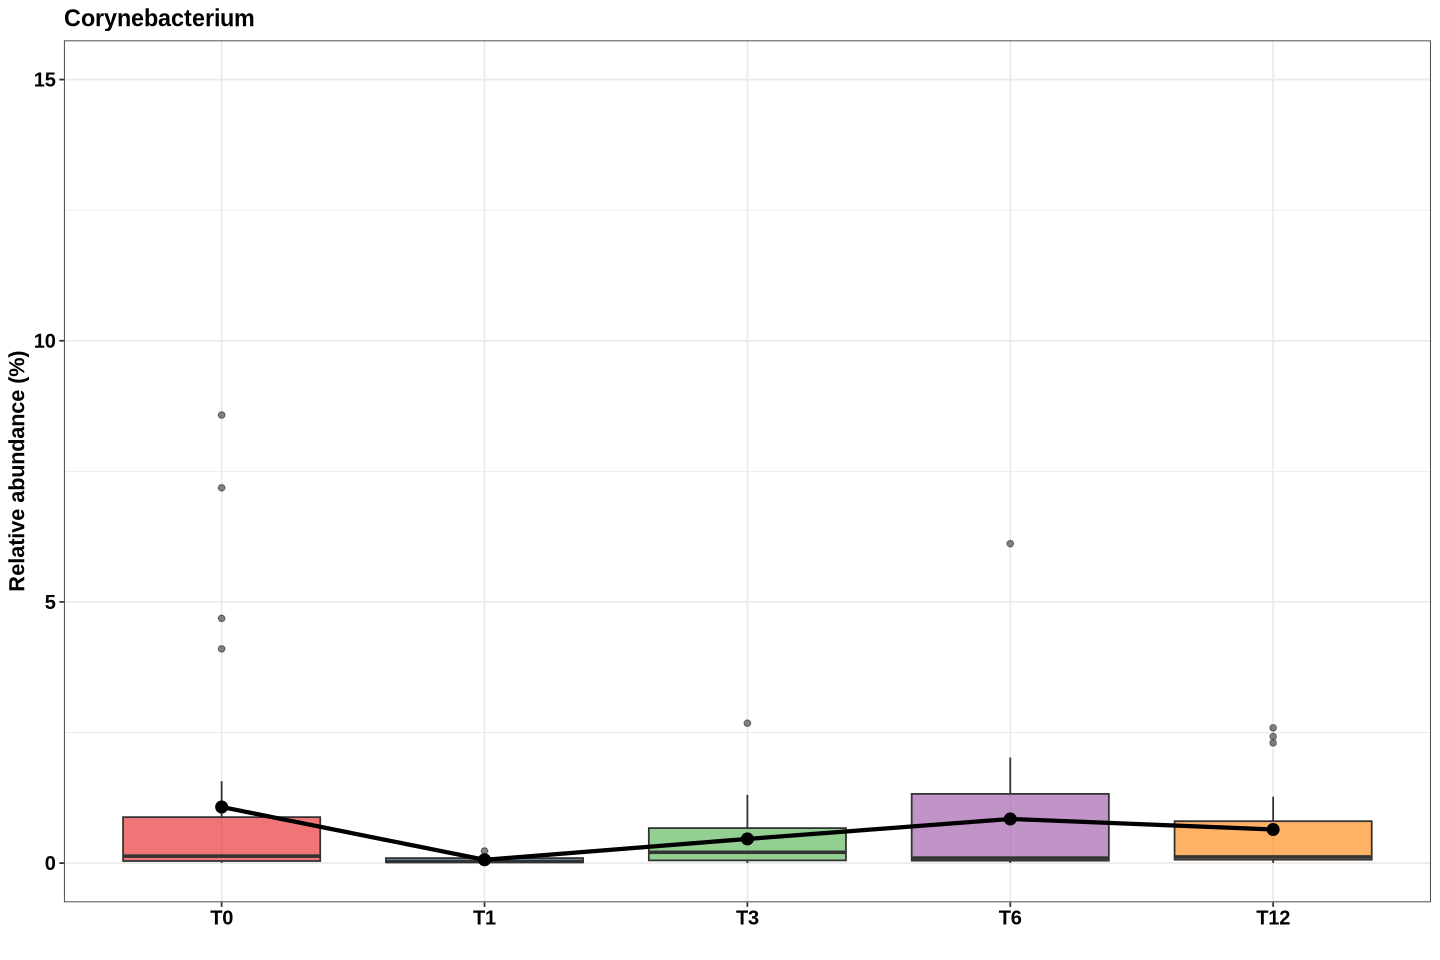

In [90]:
# Plot changes in the relative abundance of specific genus across timepoints
## Filter for Genus: Corynebacterium
df_coryne <- df_species %>%
  filter(Genus == "Corynebacterium")

## Sum relative abundance per sample across all Coryne species
df_coryne_genus <- df_coryne %>%
  group_by(ID_Sample, Timepoint) %>%
  summarise(RelAbund = sum(RelAbund), .groups = "drop")

## Compute timepoint-wise mean
means_coryne <- df_coryne_genus %>%
  group_by(Timepoint) %>%
  summarise(Mean = mean(RelAbund), .groups = "drop")

## Plot Corynebacterium spp.
p_coryne_genus <- ggplot(df_coryne_genus, aes(x = Timepoint, y = RelAbund)) +
  geom_boxplot(aes(fill = Timepoint), alpha = 0.6) +
  stat_summary(fun = mean, geom = "point", shape = 21, size = 3, fill = "black") +
  geom_line(data = means_coryne, aes(x = Timepoint, y = Mean, group = 1), color = "black", linewidth = 1.2) +
  geom_point(data = means_coryne, aes(x = Timepoint, y = Mean), color = "black", size = 2.5) +
  # stat_compare_means(
  #   comparisons = my_comparisons,
  #   method = "wilcox.test",
  #   p.adjust.method = "bonferroni",
  #   label = "p.signif",
  #   tip.length = 0.01,
  #   size = 3
  # ) +
  theme_bw() +
  labs(
    title = "Corynebacterium",
    y = "Relative abundance (%)",
    x = ""
  ) +
  scale_fill_brewer(palette = "Set1") +
  scale_y_continuous(limits = c(0, 15)) +  # extends the y-axis
  theme(
    plot.title = element_text(size = 14, face = "bold"),
    axis.title.y = element_text(size = 13, face = "bold"),
    axis.text.y = element_text(size = 12, face = "bold", color = "black"),
    axis.text.x = element_text(size = 12, face = "bold", color = "black"),
    strip.text = element_text(face = "bold"),
    legend.title = element_text(face = "bold"),
    legend.text = element_text(face = "bold"),
    legend.position = "none"
  )
p_coryne_genus

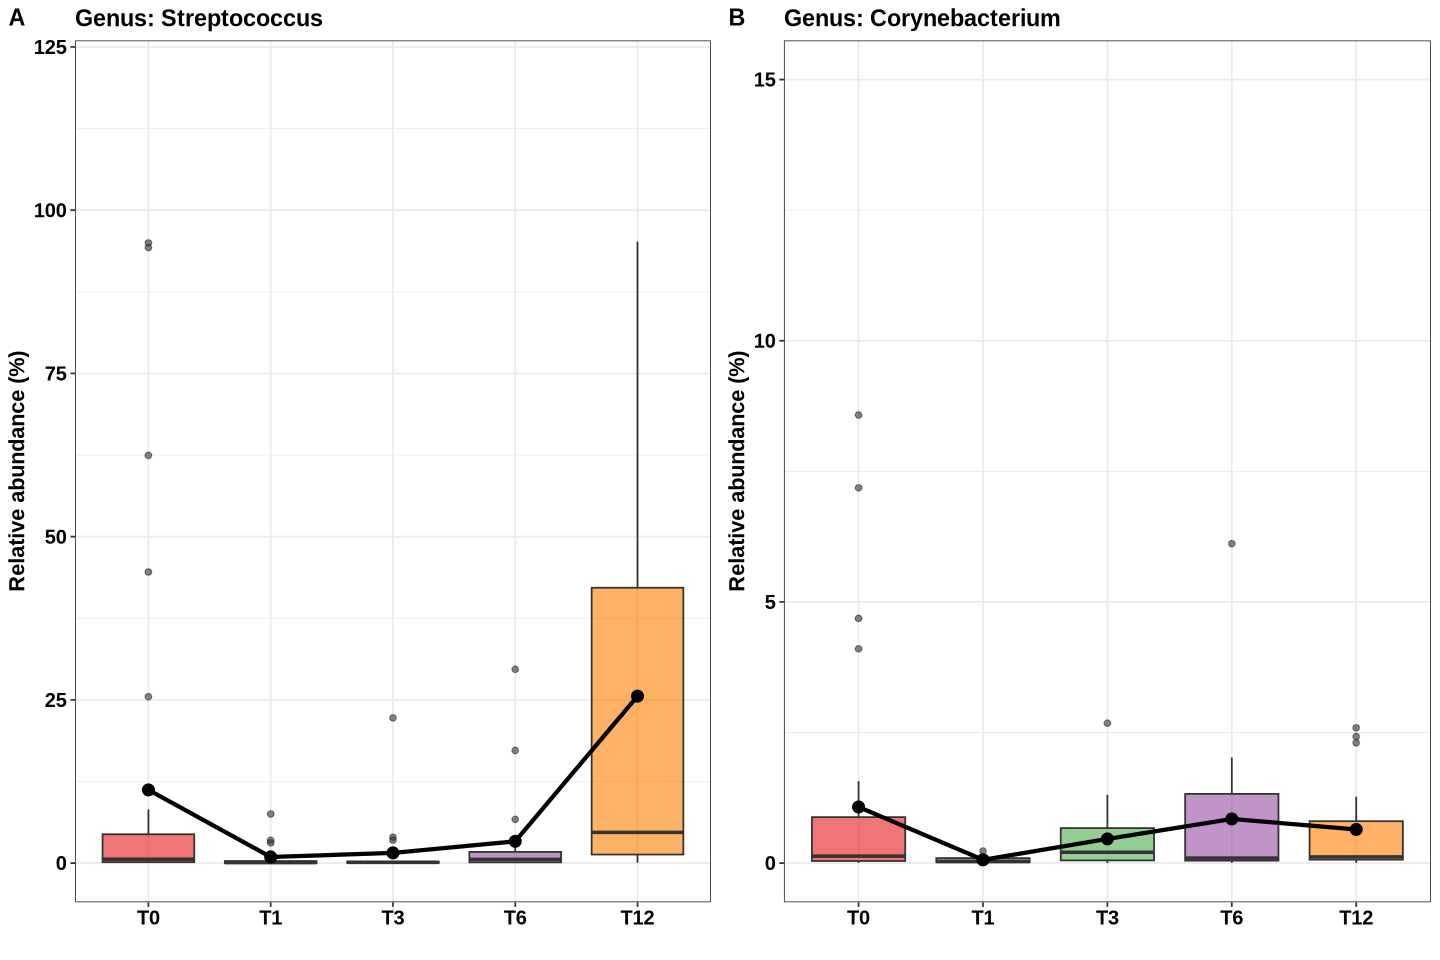

In [82]:
combined_suppl_plot <- ggarrange(
  p_strepto_genus,
  p_coryne_genus,
  labels = c("A", "B"),
  ncol = 2, nrow = 1,
  common.legend = FALSE
)

combined_suppl_plot

ggsave("combined_suppl_plot.png", combined_suppl_plot, width = 12, height = 6, dpi = 300)

Warning message:
“Removed 1 row containing non-finite outside the scale range (`stat_boxplot()`).”
Warning message:
“Removed 1 row containing non-finite outside the scale range (`stat_summary()`).”


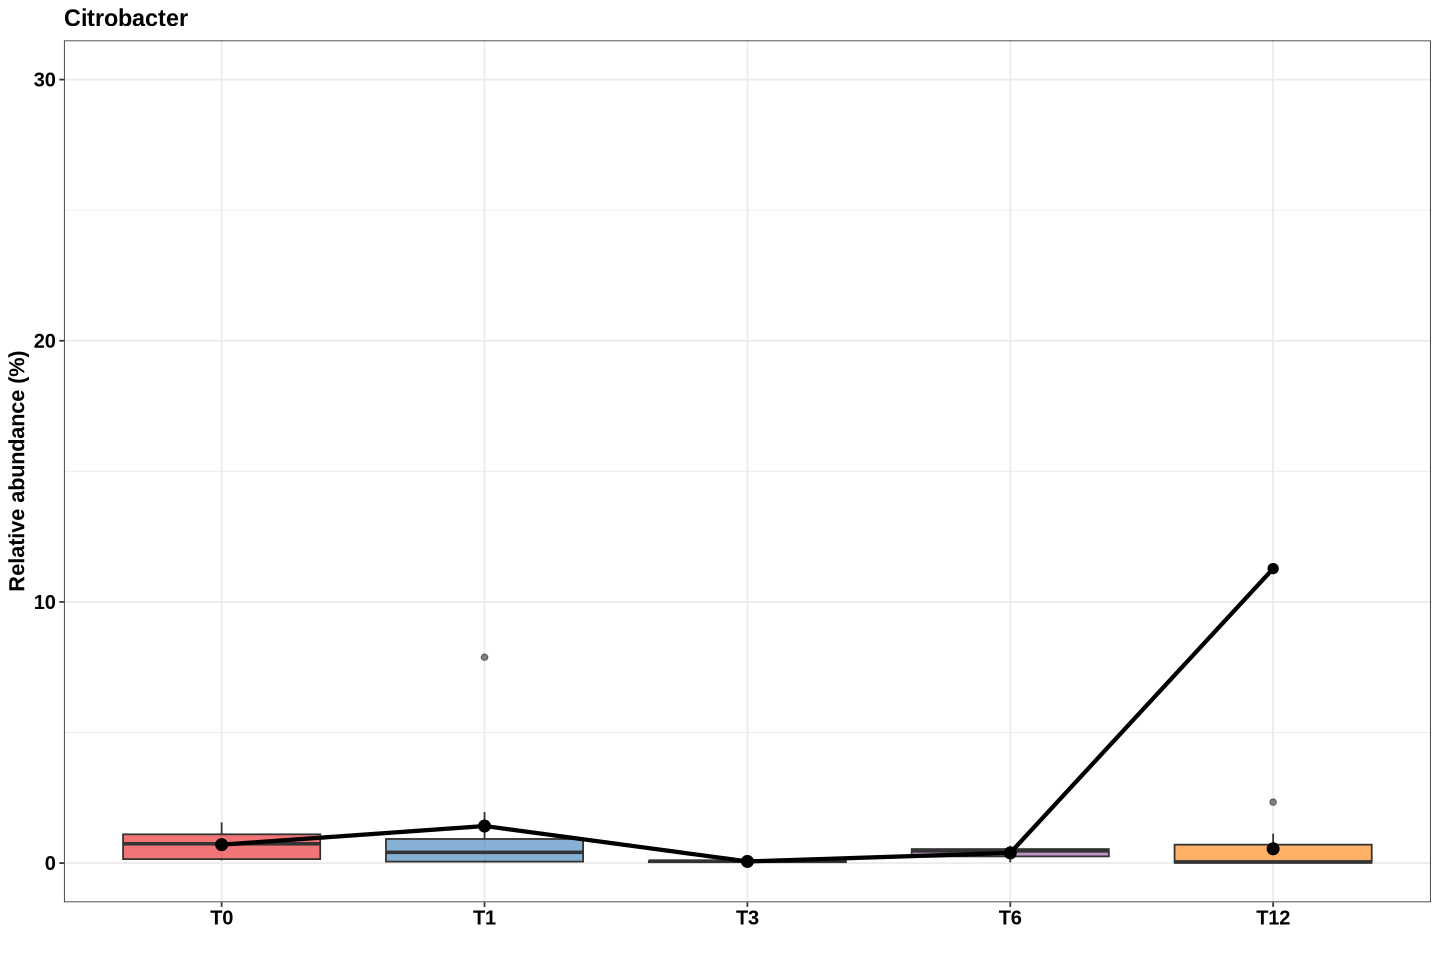

In [93]:
# Plot changes in the relative abundance of specific genus across timepoints
## Filter for Genus: Citrobacter
df_citro <- df_species %>%
  filter(Genus %in% c("Citrobacter"))

## Sum relative abundance per sample across all Citrobacter species
df_citro_genus <- df_citro %>%
  group_by(ID_Sample, Timepoint) %>%
  summarise(RelAbund = sum(RelAbund), .groups = "drop")

## Compute timepoint-wise mean
means_citro <- df_citro_genus %>%
  group_by(Timepoint) %>%
  summarise(Mean = mean(RelAbund), .groups = "drop")

## Plot
p_citro_genus <- ggplot(df_citro_genus, aes(x = Timepoint, y = RelAbund)) +
  geom_boxplot(aes(fill = Timepoint), alpha = 0.6) +
  stat_summary(fun = mean, geom = "point", shape = 21, size = 3, 
               fill = "black") +
  geom_line(data = means_citro, aes(x = Timepoint, y = Mean, group = 1), 
            color = "black", linewidth = 1.2) +
  geom_point(data = means_citro, aes(x = Timepoint, y = Mean), 
             color = "black", size = 2.5) +
  # scale_y_continuous(trans = "log1p", expand = expansion(mult = c(0, 0.25))) +
  # stat_compare_means(
  #   comparisons = my_comparisons,
  #   method = "wilcox.test",
  #   p.adjust.method = "bonferroni",
  #   label = "p.signif",
  #   tip.length = 0.01,
  #   size = 3
  # ) +
  theme_bw() +
  labs(
    title = "Citrobacter",
    y = "Relative abundance (%)",
    x = ""
  ) +
  scale_fill_brewer(palette = "Set1") +
  scale_y_continuous(limits = c(0, 30)) +  # extends the y-axis
  theme(
    plot.title = element_text(size = 14, face = "bold"),
    axis.title.y = element_text(size = 13, face = "bold"),
    axis.text.y = element_text(size = 12, face = "bold", color = "black"),
    axis.text.x = element_text(size = 12, face = "bold", color = "black"),
    strip.text = element_text(face = "bold"),
    legend.title = element_text(face = "bold"),
    legend.text = element_text(face = "bold"),
    legend.position = "none"
  )

p_citro_genus

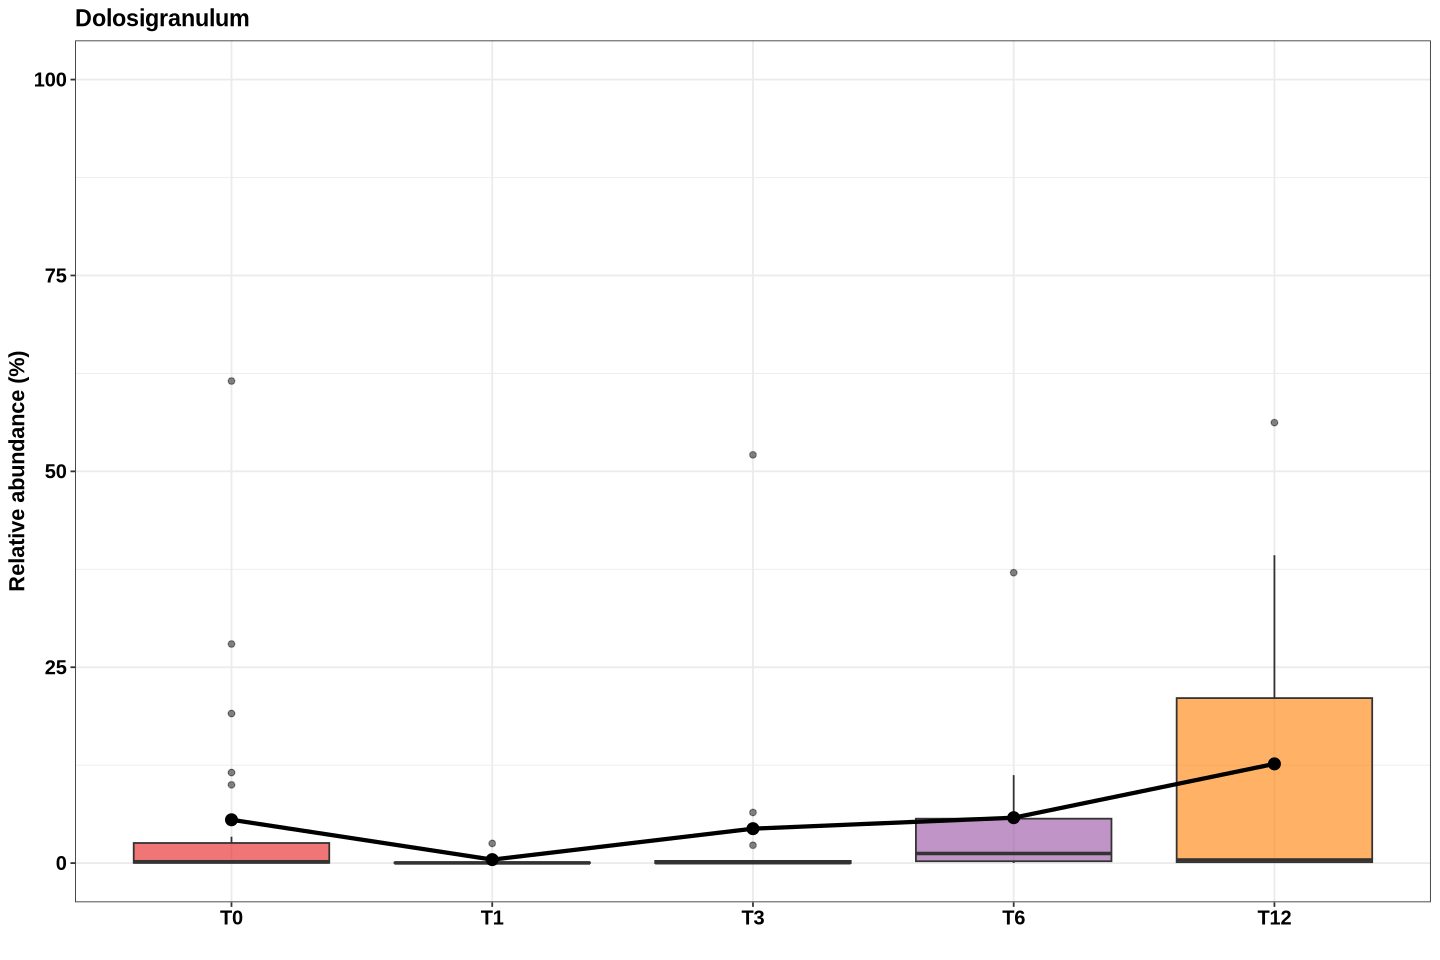

In [94]:
# Plot changes in the relative abundance of specific genus across timepoints
## Filter for Genus: Dolosigranulum
df_dolos <- df_species %>%
  filter(Genus %in% c("Dolosigranulum"))

## Sum relative abundance per sample across all Dolosigranulum species
df_dolos_genus <- df_dolos %>%
  group_by(ID_Sample, Timepoint) %>%
  summarise(RelAbund = sum(RelAbund), .groups = "drop")

## Compute timepoint-wise mean
means_dolos <- df_dolos_genus %>%
  group_by(Timepoint) %>%
  summarise(Mean = mean(RelAbund), .groups = "drop")

## Plot
p_dolos_genus <- ggplot(df_dolos_genus, aes(x = Timepoint, y = RelAbund)) +
  geom_boxplot(aes(fill = Timepoint), alpha = 0.6) +
  stat_summary(fun = mean, geom = "point", shape = 21, size = 3, 
               fill = "black") +
  geom_line(data = means_dolos, aes(x = Timepoint, y = Mean, group = 1), 
            color = "black", linewidth = 1.2) +
  geom_point(data = means_dolos, aes(x = Timepoint, y = Mean), 
             color = "black", size = 2.5) +
  scale_y_continuous(limits = c(0, 100)) +  # extends the y-axis
  # scale_y_continuous(trans = "log1p", expand = expansion(mult = c(0, 0.25))) +
  # stat_compare_means(
  #   comparisons = my_comparisons,
  #   method = "wilcox.test",
  #   p.adjust.method = "bonferroni",
  #   label = "p.signif",
  #   tip.length = 0.01,
  #   size = 3
  # ) +
  theme_bw() +
  labs(
    title = "Dolosigranulum",
    y = "Relative abundance (%)",
    x = ""
  ) +
  scale_fill_brewer(palette = "Set1") +
  theme(
    plot.title = element_text(size = 14, face = "bold"),
    axis.title.y = element_text(size = 13, face = "bold"),
    axis.text.y = element_text(size = 12, face = "bold", color = "black"),
    axis.text.x = element_text(size = 12, face = "bold", color = "black"),
    strip.text = element_text(face = "bold"),
    legend.title = element_text(face = "bold"),
    legend.text = element_text(face = "bold"),
    legend.position = "none"
  )

p_dolos_genus

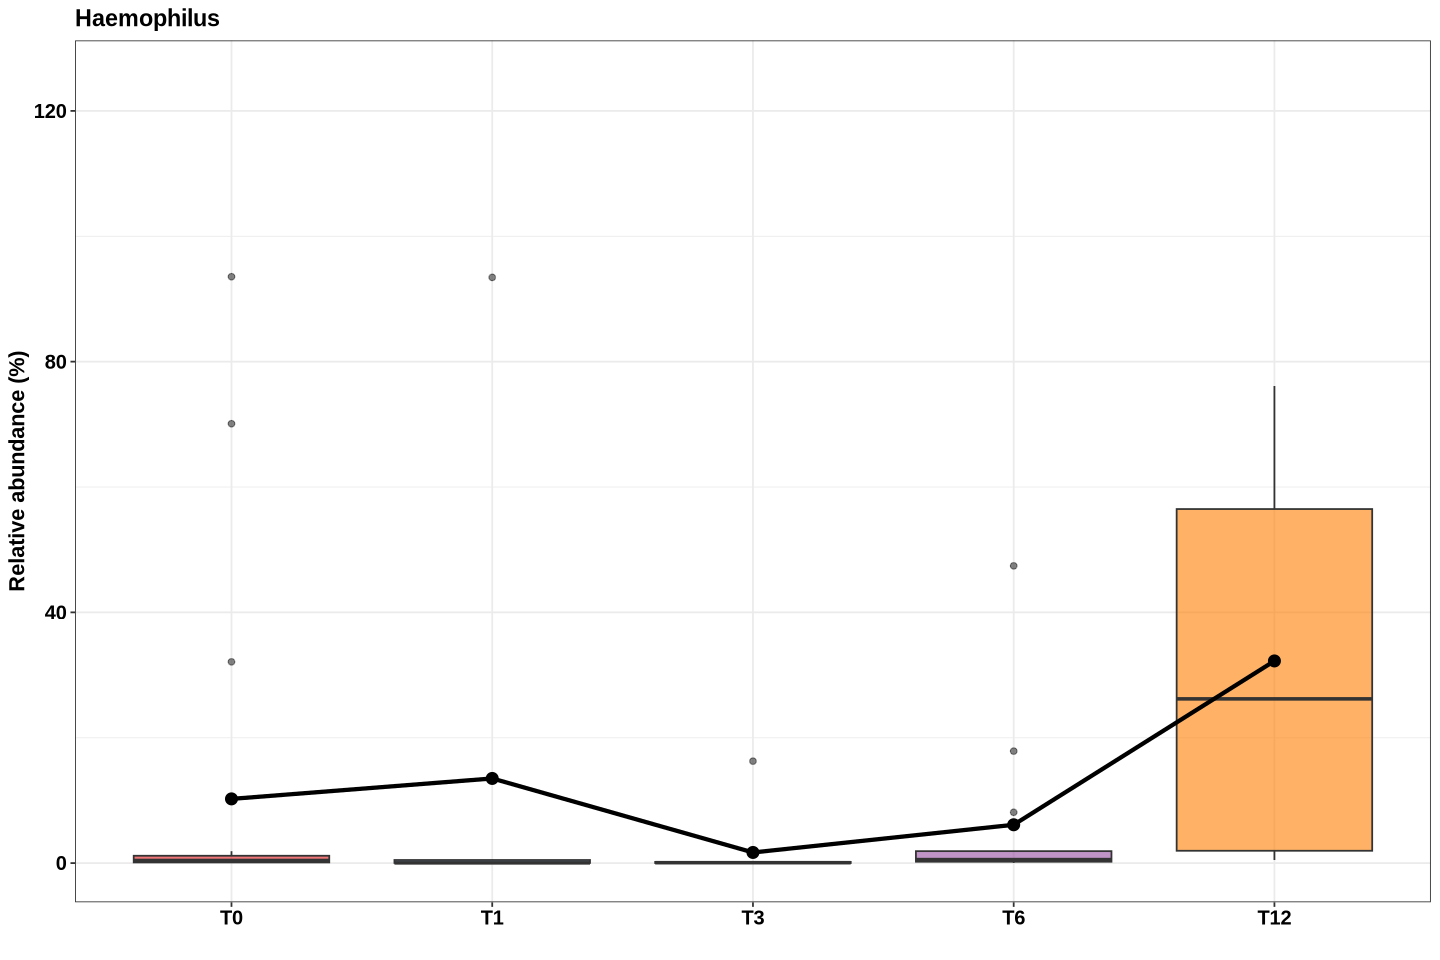

In [96]:
# Plot changes in the relative abundance of specific genus across timepoints
## Filter for Genus: Haemophilus
df_haemo <- df_species %>%
  filter(Genus %in% c("Haemophilus"))

## Sum relative abundance per sample across all Haemophilus species
df_haemo_genus <- df_haemo %>%
  group_by(ID_Sample, Timepoint) %>%
  summarise(RelAbund = sum(RelAbund), .groups = "drop")

## Compute timepoint-wise mean
means_haemo <- df_haemo_genus %>%
  group_by(Timepoint) %>%
  summarise(Mean = mean(RelAbund), .groups = "drop")

## Plot
p_haemo_genus <- ggplot(df_haemo_genus, aes(x = Timepoint, y = RelAbund)) +
  geom_boxplot(aes(fill = Timepoint), alpha = 0.6) +
  stat_summary(fun = mean, geom = "point", shape = 21, size = 3, 
               fill = "black") +
  geom_line(data = means_haemo, aes(x = Timepoint, y = Mean, group = 1), 
            color = "black", linewidth = 1.2) +
  geom_point(data = means_haemo, aes(x = Timepoint, y = Mean), 
             color = "black", size = 2.5) +
  scale_y_continuous(limits = c(0, 125)) +  # extends the y-axis
  # scale_y_continuous(trans = "log1p", expand = expansion(mult = c(0, 0.25))) +
  # stat_compare_means(
  #   comparisons = my_comparisons,
  #   method = "wilcox.test",
  #   p.adjust.method = "bonferroni",
  #   label = "p.signif",
  #   tip.length = 0.01,
  #   size = 3
  # ) +
  theme_bw() +
  labs(
    title = "Haemophilus",
    y = "Relative abundance (%)",
    x = ""
  ) +
  scale_fill_brewer(palette = "Set1") +
  theme(
    plot.title = element_text(size = 14, face = "bold"),
    axis.title.y = element_text(size = 13, face = "bold"),
    axis.text.y = element_text(size = 12, face = "bold", color = "black"),
    axis.text.x = element_text(size = 12, face = "bold", color = "black"),
    strip.text = element_text(face = "bold"),
    legend.title = element_text(face = "bold"),
    legend.text = element_text(face = "bold"),
    legend.position = "none"
  )

p_haemo_genus

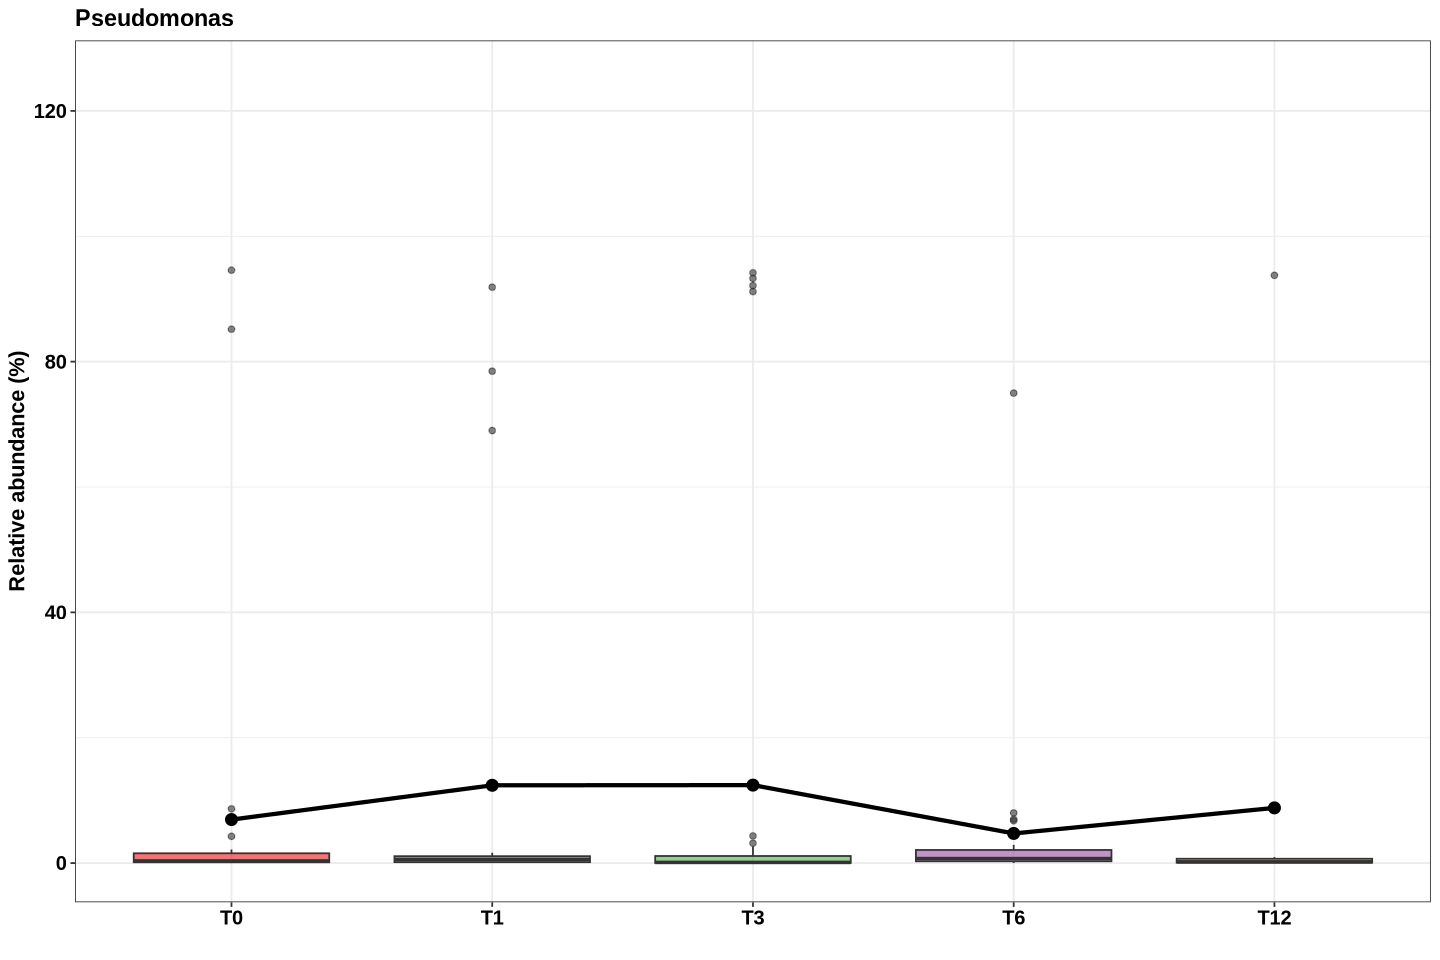

In [98]:
# Plot changes in the relative abundance of specific genus across timepoints
## Filter for Genus: Pseudomonas
df_pseudo <- df_species %>%
  filter(Genus %in% c("Pseudomonas"))

## Sum relative abundance per sample across all Pseudomonas species
df_pseudo_genus <- df_pseudo %>%
  group_by(ID_Sample, Timepoint) %>%
  summarise(RelAbund = sum(RelAbund), .groups = "drop")

## Compute timepoint-wise mean
means_pseudo <- df_pseudo_genus %>%
  group_by(Timepoint) %>%
  summarise(Mean = mean(RelAbund), .groups = "drop")

## Plot
p_pseudo_genus <- ggplot(df_pseudo_genus, aes(x = Timepoint, y = RelAbund)) +
  geom_boxplot(aes(fill = Timepoint), alpha = 0.6) +
  stat_summary(fun = mean, geom = "point", shape = 21, size = 3, 
               fill = "black") +
  geom_line(data = means_pseudo, aes(x = Timepoint, y = Mean, group = 1), 
            color = "black", linewidth = 1.2) +
  geom_point(data = means_pseudo, aes(x = Timepoint, y = Mean), 
             color = "black", size = 2.5) +
  scale_y_continuous(limits = c(0, 125)) +  # extends the y-axis
  # scale_y_continuous(trans = "log1p", expand = expansion(mult = c(0, 0.25))) +
  # stat_compare_means(
  #   comparisons = my_comparisons,
  #   method = "wilcox.test",
  #   p.adjust.method = "bonferroni",
  #   label = "p.signif",
  #   tip.length = 0.01,
  #   size = 3
  # ) +
  theme_bw() +
  labs(
    title = "Pseudomonas",
    y = "Relative abundance (%)",
    x = ""
  ) +
  scale_fill_brewer(palette = "Set1") +
  theme(
    plot.title = element_text(size = 14, face = "bold"),
    axis.title.y = element_text(size = 13, face = "bold"),
    axis.text.y = element_text(size = 12, face = "bold", color = "black"),
    axis.text.x = element_text(size = 12, face = "bold", color = "black"),
    strip.text = element_text(face = "bold"),
    legend.title = element_text(face = "bold"),
    legend.text = element_text(face = "bold"),
    legend.position = "none"
  )

p_pseudo_genus

In [76]:
head(df_esche)

Taxa,ID_Sample,Timepoint,Counts,Genus,RelAbund,Taxa_clean
<chr>,<chr>,<fct>,<int>,<chr>,<dbl>,<chr>
Escherichia coli,0130765A_T0,T0,15,Escherichia,0.4447080,Escherichia coli
Escherichia coli TOP498,0130765A_T0,T0,1,Escherichia,0.0296472,Escherichia coli
Shigella dysenteriae,0130765A_T0,T0,7,Shigella,0.2075304,Shigella dysenteriae
Shigella flexneri,0130765A_T0,T0,7,Shigella,0.2075304,Shigella flexneri
Escherichia coli,0236549G_T0,T0,7,Escherichia,0.1552106,Escherichia coli
Escherichia fergusonii,0236549G_T0,T0,7,Escherichia,0.1552106,Escherichia fergusonii


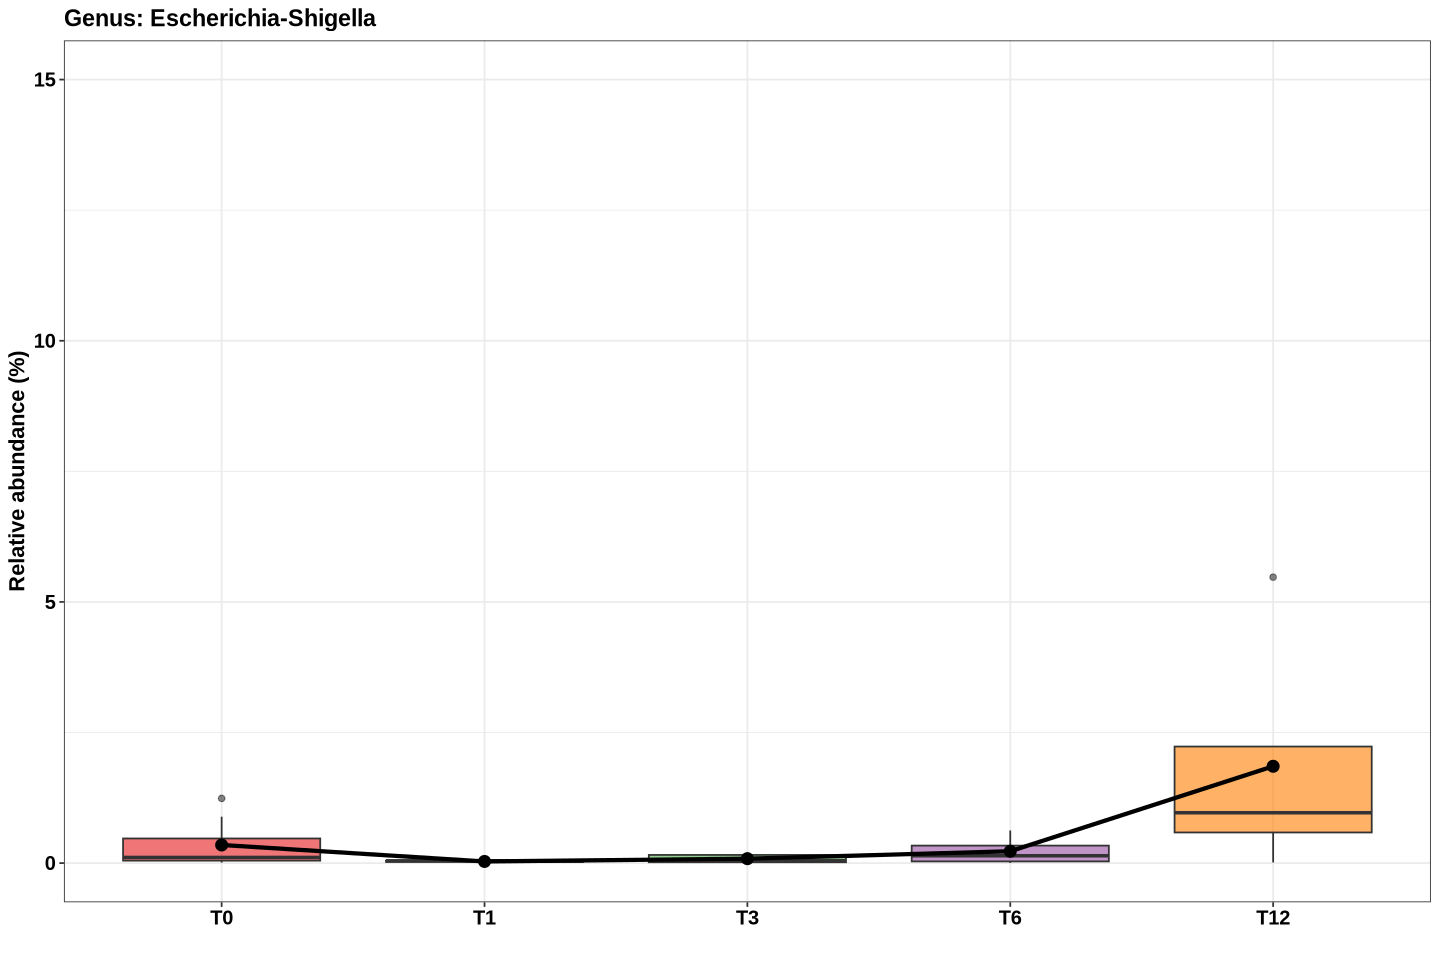

In [78]:
# Plot changes in the relative abundance of specific genus across timepoints
## Filter for Genus: Escherichia-Shigella
df_esche <- df_species %>%
  filter(Genus %in% c("Escherichia", "Shigella"))

## Sum relative abundance per sample across all Escherichia-Shigella species
df_esche_genus <- df_esche %>%
  group_by(ID_Sample, Timepoint) %>%
  summarise(RelAbund = sum(RelAbund), .groups = "drop")

## Compute timepoint-wise mean
means_esche <- df_esche_genus %>%
  group_by(Timepoint) %>%
  summarise(Mean = mean(RelAbund), .groups = "drop")

## Plot
p_esche_genus <- ggplot(df_esche_genus, aes(x = Timepoint, y = RelAbund)) +
  geom_boxplot(aes(fill = Timepoint), alpha = 0.6) +
  stat_summary(fun = mean, geom = "point", shape = 21, size = 3, 
               fill = "black") +
  geom_line(data = means_esche, aes(x = Timepoint, y = Mean, group = 1), 
            color = "black", linewidth = 1.2) +
  geom_point(data = means_esche, aes(x = Timepoint, y = Mean), 
             color = "black", size = 2.5) +
  scale_y_continuous(limits = c(0, 15)) +  # extends the y-axis
  # scale_y_continuous(trans = "log1p", expand = expansion(mult = c(0, 0.25))) +
  # stat_compare_means(
  #   comparisons = my_comparisons,
  #   method = "wilcox.test",
  #   p.adjust.method = "bonferroni",
  #   label = "p.signif",
  #   tip.length = 0.01,
  #   size = 3
  # ) +
  theme_bw() +
  labs(
    title = "Genus: Escherichia-Shigella",
    y = "Relative abundance (%)",
    x = ""
  ) +
  scale_fill_brewer(palette = "Set1") +
  theme(
    plot.title = element_text(size = 14, face = "bold"),
    axis.title.y = element_text(size = 13, face = "bold"),
    axis.text.y = element_text(size = 12, face = "bold", color = "black"),
    axis.text.x = element_text(size = 12, face = "bold", color = "black"),
    strip.text = element_text(face = "bold"),
    legend.title = element_text(face = "bold"),
    legend.text = element_text(face = "bold"),
    legend.position = "none"
  )

p_esche_genus

Warning message:
“Removed 1 row containing non-finite outside the scale range (`stat_boxplot()`).”
Warning message:
“Removed 1 row containing non-finite outside the scale range (`stat_summary()`).”


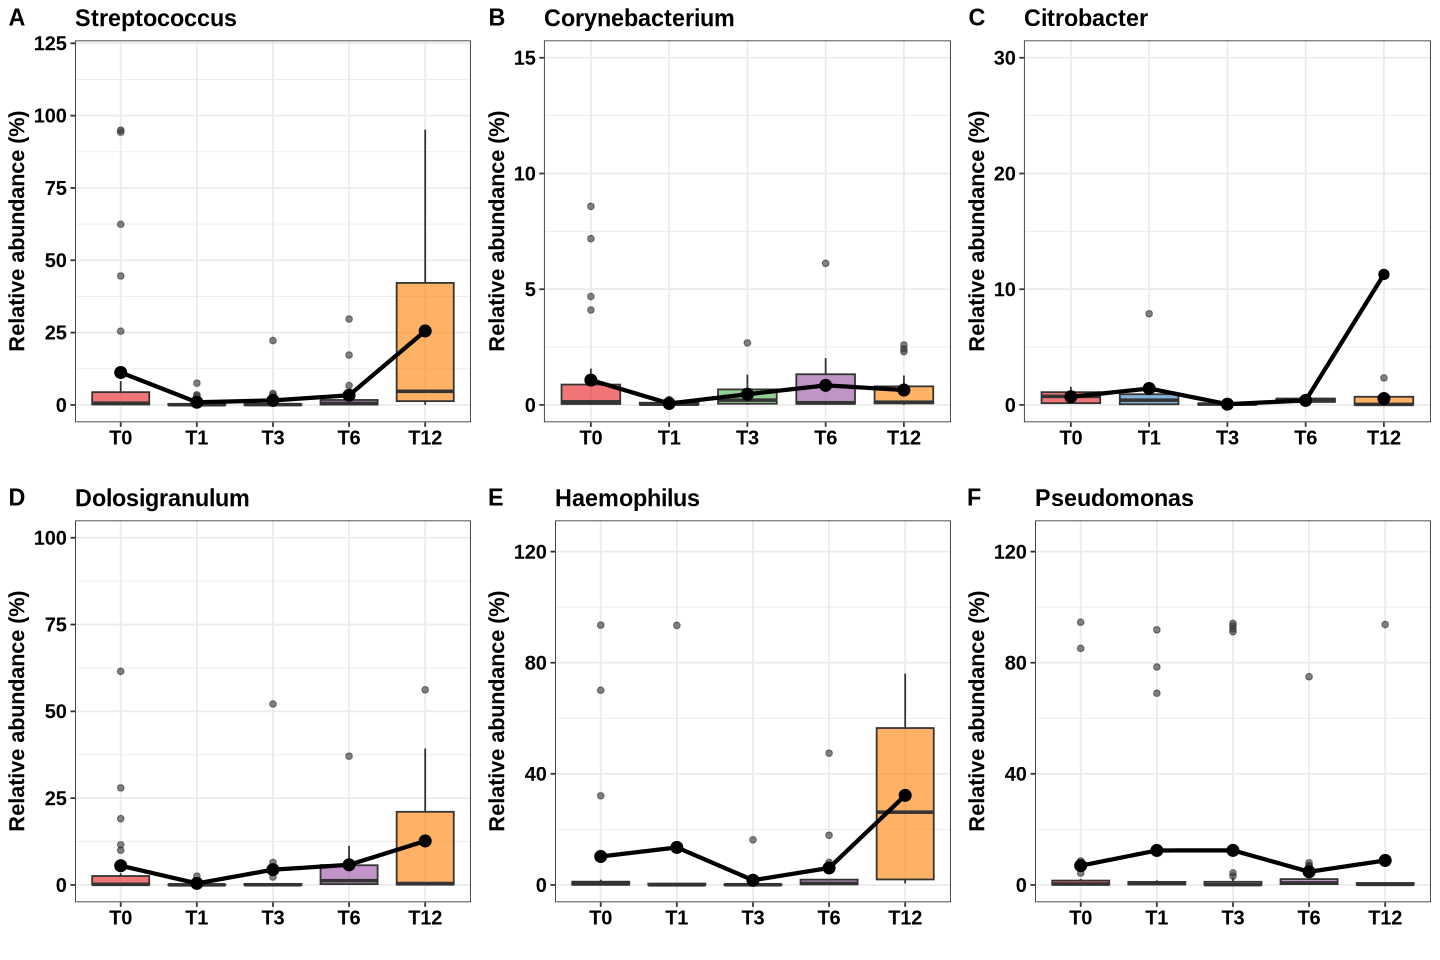

In [100]:
# Combine all in a single pannel 

combined_suppl_plot2 <- ggarrange(
  p_strepto_genus,
  p_coryne_genus,
  p_citro_genus,
  p_dolos_genus,
  p_haemo_genus, 
  p_pseudo_genus,
  # p_esche_genus,
  labels = c("A", "B", "C", "D", "E", "F", "G"),
  ncol = 3, nrow = 2,
  common.legend = FALSE
)
combined_suppl_plot2
    

ggsave("combined_suppl_plot2.png", 
       combined_suppl_plot2, width = 12, height = 8, dpi = 300)

In [54]:
head(df_species)
write.table(df_species, file = "df_species.tsv", quote = FALSE, sep = "\t", row.names = F)

Taxa,ID_Sample,Timepoint,Counts,Genus,RelAbund,Taxa_clean
<chr>,<chr>,<fct>,<int>,<chr>,<dbl>,<chr>
[Propionibacterium] namnetense,0088303G_T0,T0,1,[Propionibacterium],0.01600512,[Propionibacterium] namnetense
Anaerococcus octavius,0088303G_T0,T0,4,Anaerococcus,0.06402049,Anaerococcus octavius
bacterium,0088303G_T0,T0,8,bacterium,0.12804097,NA
bacterium 1-gw1-3,0088303G_T0,T0,9,bacterium,0.14404609,bacterium 1-gw1-3
bacterium HKG213,0088303G_T0,T0,16,bacterium,0.25608195,bacterium HKG213
bacterium N47,0088303G_T0,T0,21,bacterium,0.33610755,bacterium N47


`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?
`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?
`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?
`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?
`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?
`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?
`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?
`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?
`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?
`geom_line()`: Each group consists of only one observat

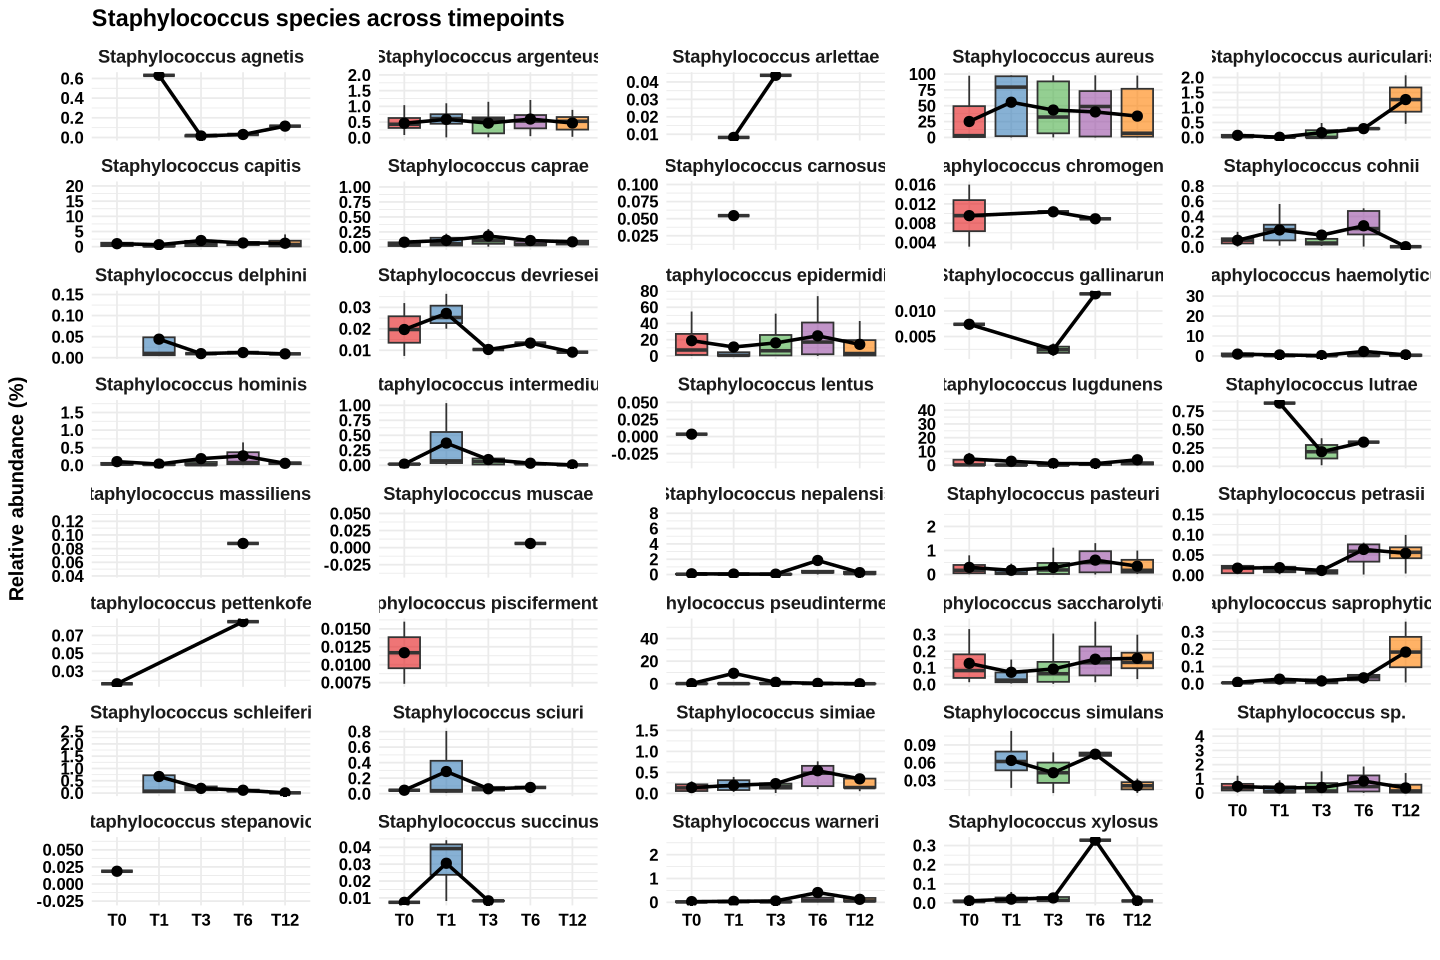

In [72]:
## Filter for Staphylococcus species
staph_species_plot <- df_species %>%
  filter(Genus == "Staphylococcus") %>%
  group_by(ID_Sample, Timepoint, Taxa_clean) %>%
  summarise(RelativeAbundance = sum(RelAbund), .groups = "drop")

## Compute timepoint-wise mean for each species
means_species <- staph_species_plot %>%
  group_by(Timepoint, Taxa_clean) %>%
  summarise(Mean = mean(RelativeAbundance), .groups = "drop")

## Plot with facet per species
p_species_facet <- ggplot(staph_species_plot, aes(x = Timepoint, y = RelativeAbundance)) +
  geom_boxplot(aes(fill = Timepoint), alpha = 0.6, outlier.shape = NA) +
  stat_summary(fun = mean, geom = "point", shape = 21, size = 2.5, fill = "black") +
  geom_line(data = means_species, aes(x = Timepoint, y = Mean, group = Taxa_clean), color = "black", linewidth = 1) +
  geom_point(data = means_species, aes(x = Timepoint, y = Mean), color = "black", size = 2) +
  facet_wrap(~ Taxa_clean, scales = "free_y", ncol = 5) +
  theme_minimal() +
  labs(
    title = "Staphylococcus species across timepoints",
    y = "Relative abundance (%)",
    x = ""
  ) +
  scale_fill_brewer(palette = "Set1") +
  theme(
    strip.text = element_text(size = 11, face = "bold"),
    axis.text = element_text(size = 10, face = "bold", color = "black"),
    axis.title.y = element_text(size = 12, face = "bold"),
    plot.title = element_text(size = 14, face = "bold"),
    legend.position = "none"
  )

p_species_facet

ggsave("staph_abund_timepoints.png", p_species_facet, width = 12, height = 10, dpi = 300)

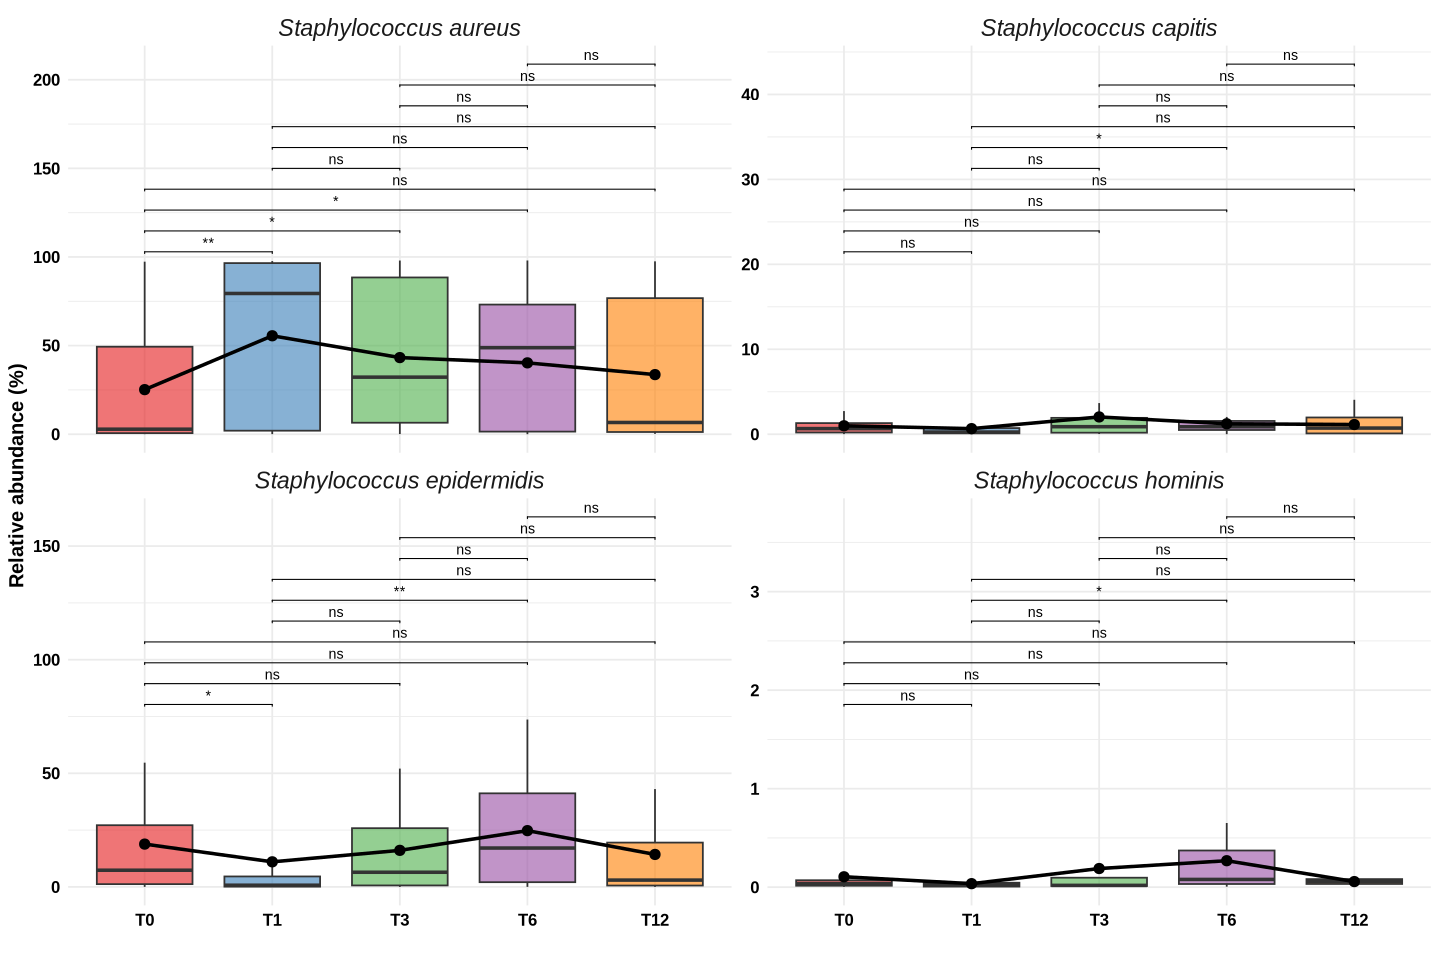

In [73]:
# Re-do plot with most interesting Staphspecies
## Define species of interest
interesting_species <- c(
  "Staphylococcus aureus",
  "Staphylococcus epidermidis",
  "Staphylococcus capitis", 
  "Staphylococcus hominis"
)

## Filter for Staphylococcus species of interest
staph_species_plot_filtered <- df_species %>%
  filter(Genus == "Staphylococcus", Taxa_clean %in% interesting_species) %>%
  group_by(ID_Sample, Timepoint, Taxa_clean) %>%
  summarise(RelativeAbundance = sum(RelAbund), .groups = "drop")

## Compute timepoint-wise mean for each species
means_species_filtered <- staph_species_plot_filtered %>%
  group_by(Timepoint, Taxa_clean) %>%
  summarise(Mean = mean(RelativeAbundance), .groups = "drop")

# Define pairwise comparisons for timepoints
my_comparisons <- list(
  c("T0", "T1"), c("T0", "T3"), c("T0", "T6"), c("T0", "T12"),
  c("T1", "T3"), c("T1", "T6"), c("T1", "T12"),
  c("T3", "T6"), c("T3", "T12"),
  c("T6", "T12")
)

# Re-do plot with significance annotations
p_species_filtered <- ggplot(staph_species_plot_filtered, aes(x = Timepoint, y = RelativeAbundance)) +
  geom_boxplot(aes(fill = Timepoint), alpha = 0.6, outlier.shape = NA) +
  stat_summary(fun = mean, geom = "point", shape = 21, size = 2.5, fill = "black") +
  geom_line(data = means_species_filtered, aes(x = Timepoint, y = Mean, group = Taxa_clean), color = "black", linewidth = 1) +
  geom_point(data = means_species_filtered, aes(x = Timepoint, y = Mean), color = "black", size = 2) +
  facet_wrap(~ Taxa_clean, scales = "free_y", ncol = 2) +
  stat_compare_means(
    comparisons = my_comparisons,
    method = "wilcox.test",
    p.adjust.method = "bonferroni",
    label = "p.signif",
    tip.length = 0.01,
    size = 3
  ) +
  theme_minimal() +
  labs(
    y = "Relative abundance (%)",
    x = ""
  ) +
  scale_fill_brewer(palette = "Set1") +
  theme(
    strip.text = element_text(size = 14, face = "italic"),
    axis.text = element_text(size = 10, face = "bold", color = "black"),
    axis.title.y = element_text(size = 12, face = "bold"),
    legend.position = "none"
  )

p_species_filtered

In [45]:
y_limits <- staph_species_plot_filtered %>%
  group_by(Taxa_clean) %>%
  summarise(y_max = max(RelativeAbundance, na.rm = TRUE)) %>%
  mutate(y_limit = y_max * 2)
# y_limits
staph_species_plot_filtered <- left_join(staph_species_plot_filtered, y_limits, by = "Taxa_clean")
means_species_filtered <- left_join(means_species_filtered, y_limits, by = "Taxa_clean")
head(staph_species_plot_filtered)

ID_Sample,Timepoint,Taxa_clean,RelativeAbundance,y_max,y_limit
<chr>,<fct>,<chr>,<dbl>,<dbl>,<dbl>
0001967K_T1,T1,Staphylococcus aureus,95.709177592,98.039972,196.079943
0001967K_T1,T1,Staphylococcus epidermidis,0.208581645,76.462853,152.925707
0001967K_T3,T3,Staphylococcus aureus,97.158017154,98.039972,196.079943
0001967K_T3,T3,Staphylococcus capitis,0.021805495,20.455840,40.911681
0001967K_T3,T3,Staphylococcus epidermidis,0.079953482,76.462853,152.925707
0001967K_T3,T3,Staphylococcus hominis,0.005451374,1.766382,3.532764


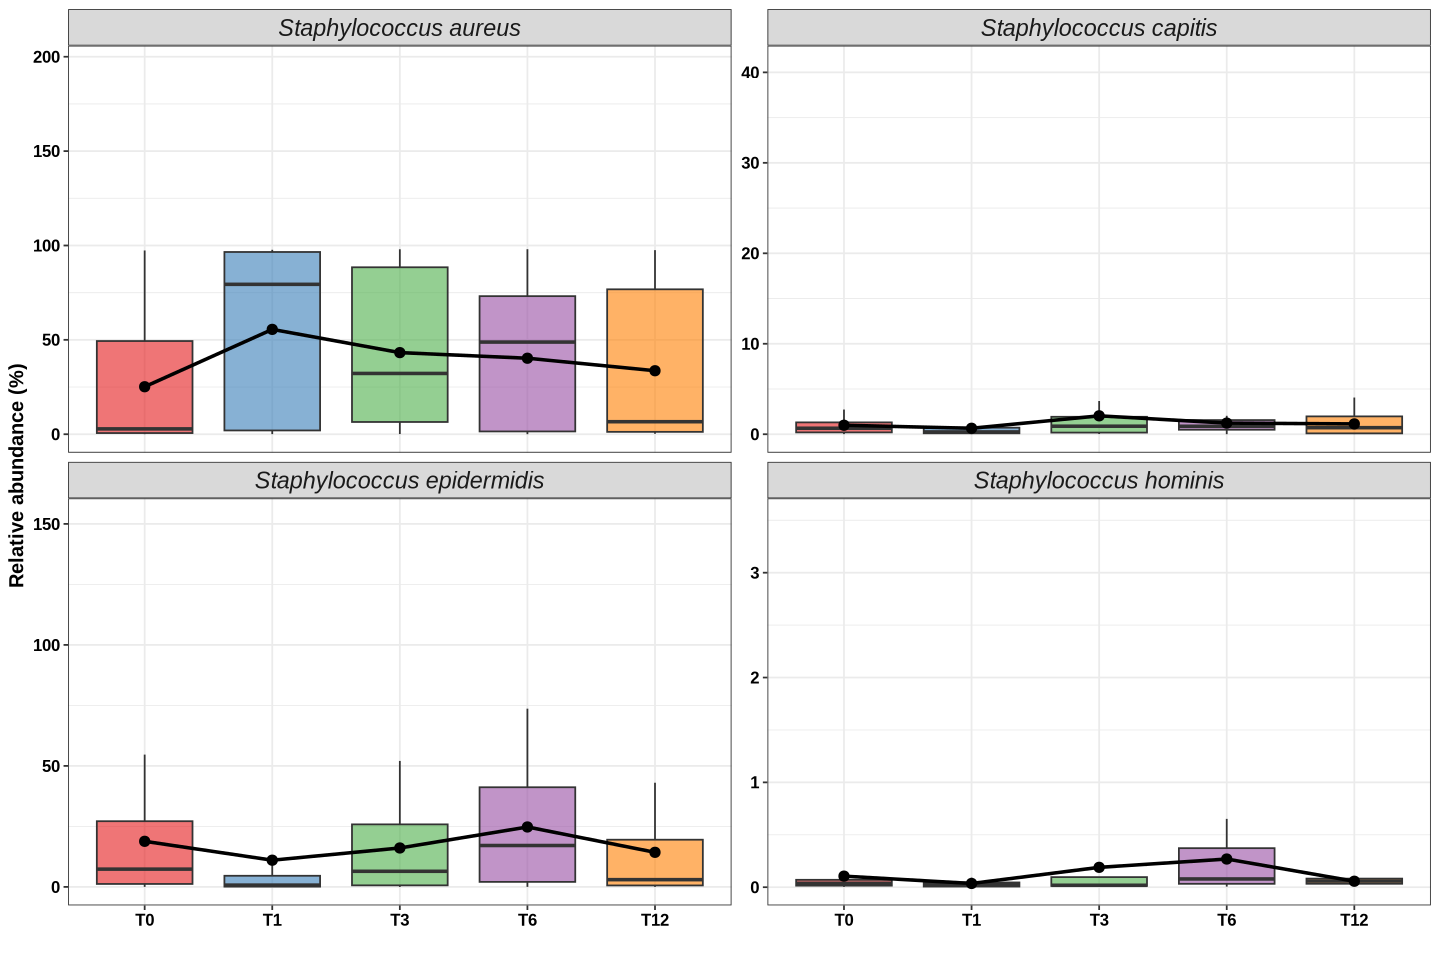

In [46]:
p_species_filtered <- ggplot(staph_species_plot_filtered, aes(x = Timepoint, y = RelativeAbundance)) +
  geom_boxplot(aes(fill = Timepoint), alpha = 0.6, outlier.shape = NA) +
  stat_summary(fun = mean, geom = "point", shape = 21, size = 2.5, fill = "black") +
  geom_line(data = means_species_filtered, aes(x = Timepoint, y = Mean, group = Taxa_clean), color = "black", linewidth = 1) +
  geom_point(data = means_species_filtered, aes(x = Timepoint, y = Mean), color = "black", size = 2) +
  geom_blank(aes(y = y_limit)) +  # This sets the y-axis per facet
  facet_wrap(~ Taxa_clean, scales = "free_y", ncol = 2) +
  theme_bw() +
  labs(
    y = "Relative abundance (%)",
    x = ""
  ) +
  scale_fill_brewer(palette = "Set1") +
  theme(
    strip.text = element_text(size = 14, face = "italic"),
    axis.text = element_text(size = 10, face = "bold", color = "black"),
    axis.title.y = element_text(size = 12, face = "bold"),
    legend.position = "none"
  )
p_species_filtered

In [47]:
ggsave("final_staph_plotB.png", p_species_filtered, width = 12, height = 12, dpi = 300)

Warning message:
“Use of `df_relab_tax_filt$Taxa` is discouraged.
ℹ Use `Taxa` instead.”
Warning message:
“Use of `df_relab_tax_filt$Taxa` is discouraged.
ℹ Use `Taxa` instead.”
Warning message:
“Use of `df_relab_tax_filt$Taxa` is discouraged.
ℹ Use `Taxa` instead.”
Warning message:
“Use of `df_relab_tax_filt$Taxa` is discouraged.
ℹ Use `Taxa` instead.”


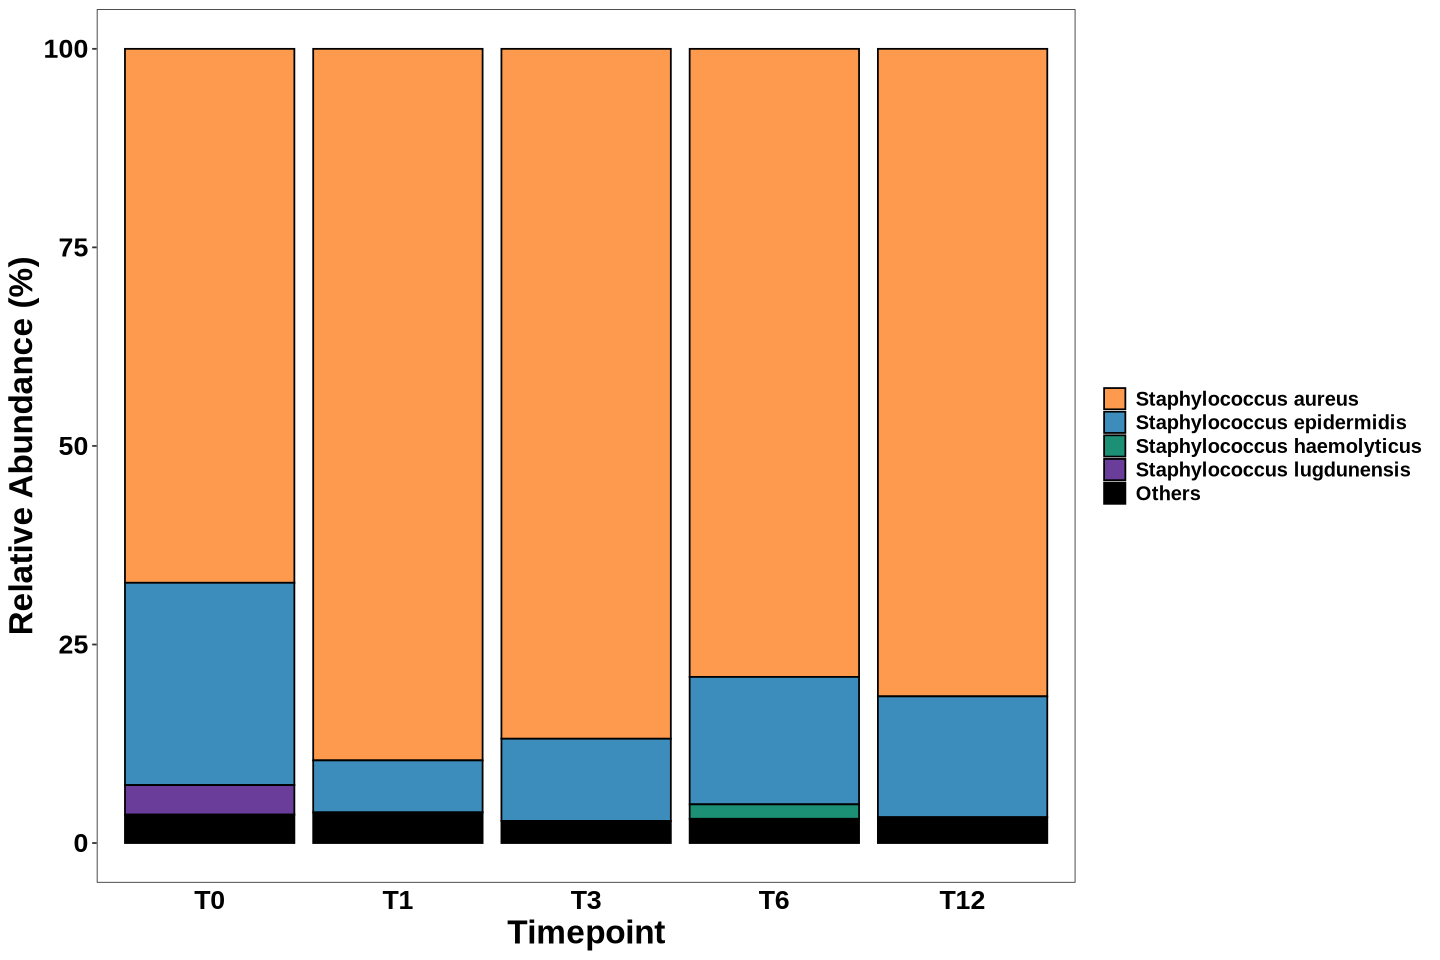

In [36]:
plot_phylum <- plot_relative_abundance(ReadCounts_TaxAnnotation, "Phylum", "Phylum_Relative_Abundance.png")
plot_family <- plot_relative_abundance(ReadCounts_TaxAnnotation, "Family", "Family_Relative_Abundance.png")
plot_genus <- plot_relative_abundance(ReadCounts_TaxAnnotation, "Genus", "Genus_Relative_Abundance.png")
plot_sp <- plot_relative_abundance(ReadCounts_TaxAnnotation, "Species", "Species_Relative_Abundance.png")
staph_plot

In [31]:
shannon_plot <- readRDS("Shannon_AlphaDiv_plot.rds")

Warning message:
“Use of `df_relab_tax_filt$Taxa` is discouraged.
ℹ Use `Taxa` instead.”
Warning message:
“Use of `df_relab_tax_filt$Taxa` is discouraged.
ℹ Use `Taxa` instead.”


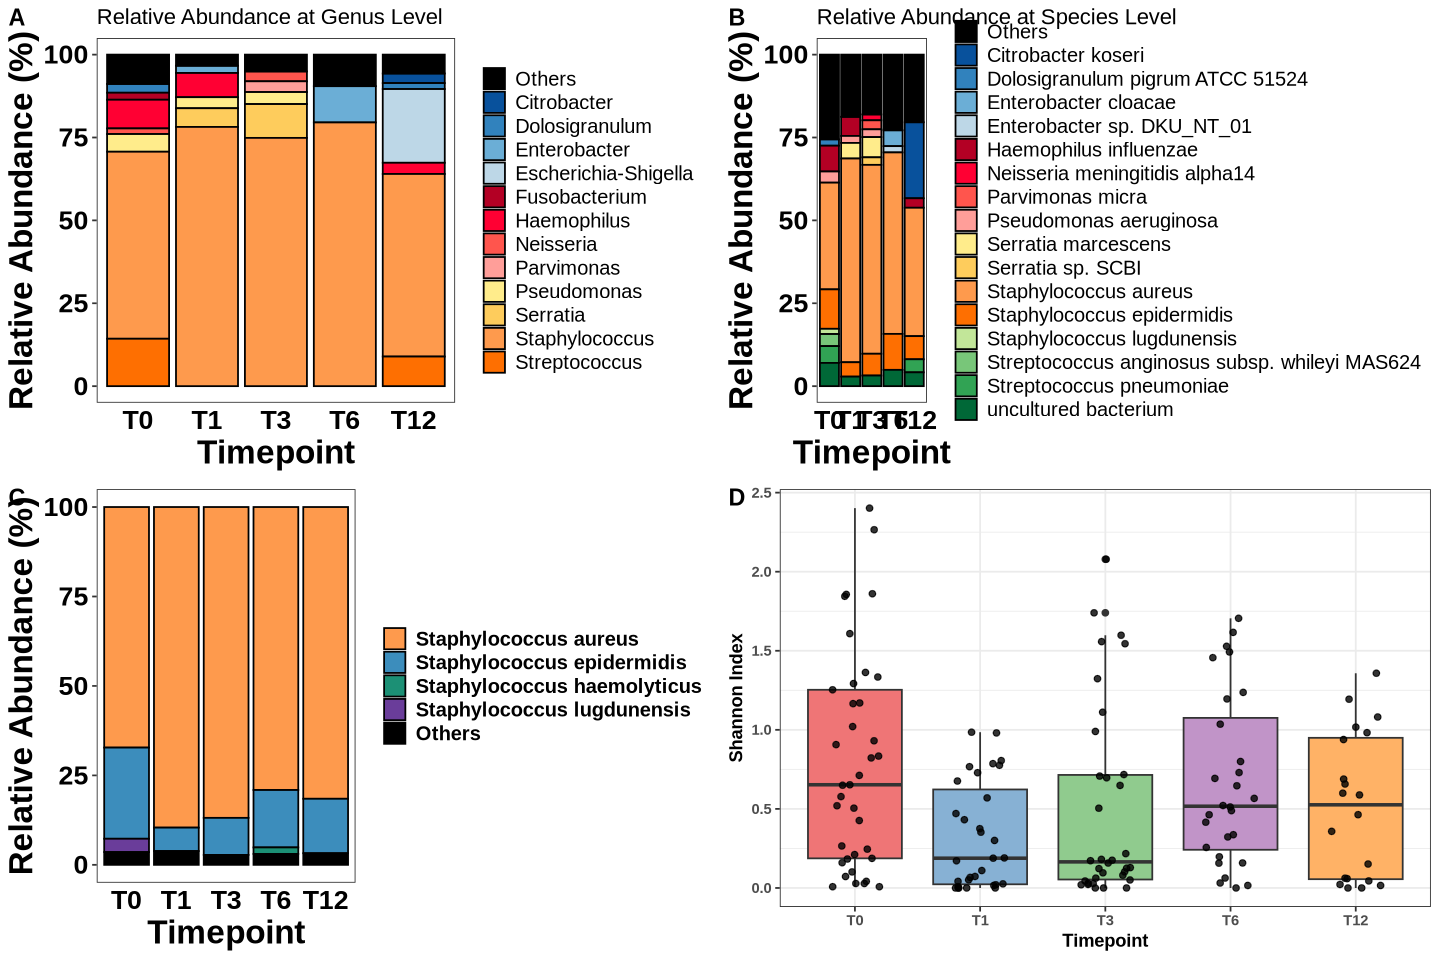

In [37]:
combined_extra_plot <- ggarrange(
  plot_genus,
  plot_sp,
  staph_plot,
  shannon_plot, 
  labels = c("A", "B", "C", "D"),
  ncol = 2, nrow = 2,
  common.legend = FALSE
)

combined_extra_plot

ggsave("combined_pannel_bars.png", combined_extra_plot, width = 28, height = 14, dpi = 300)

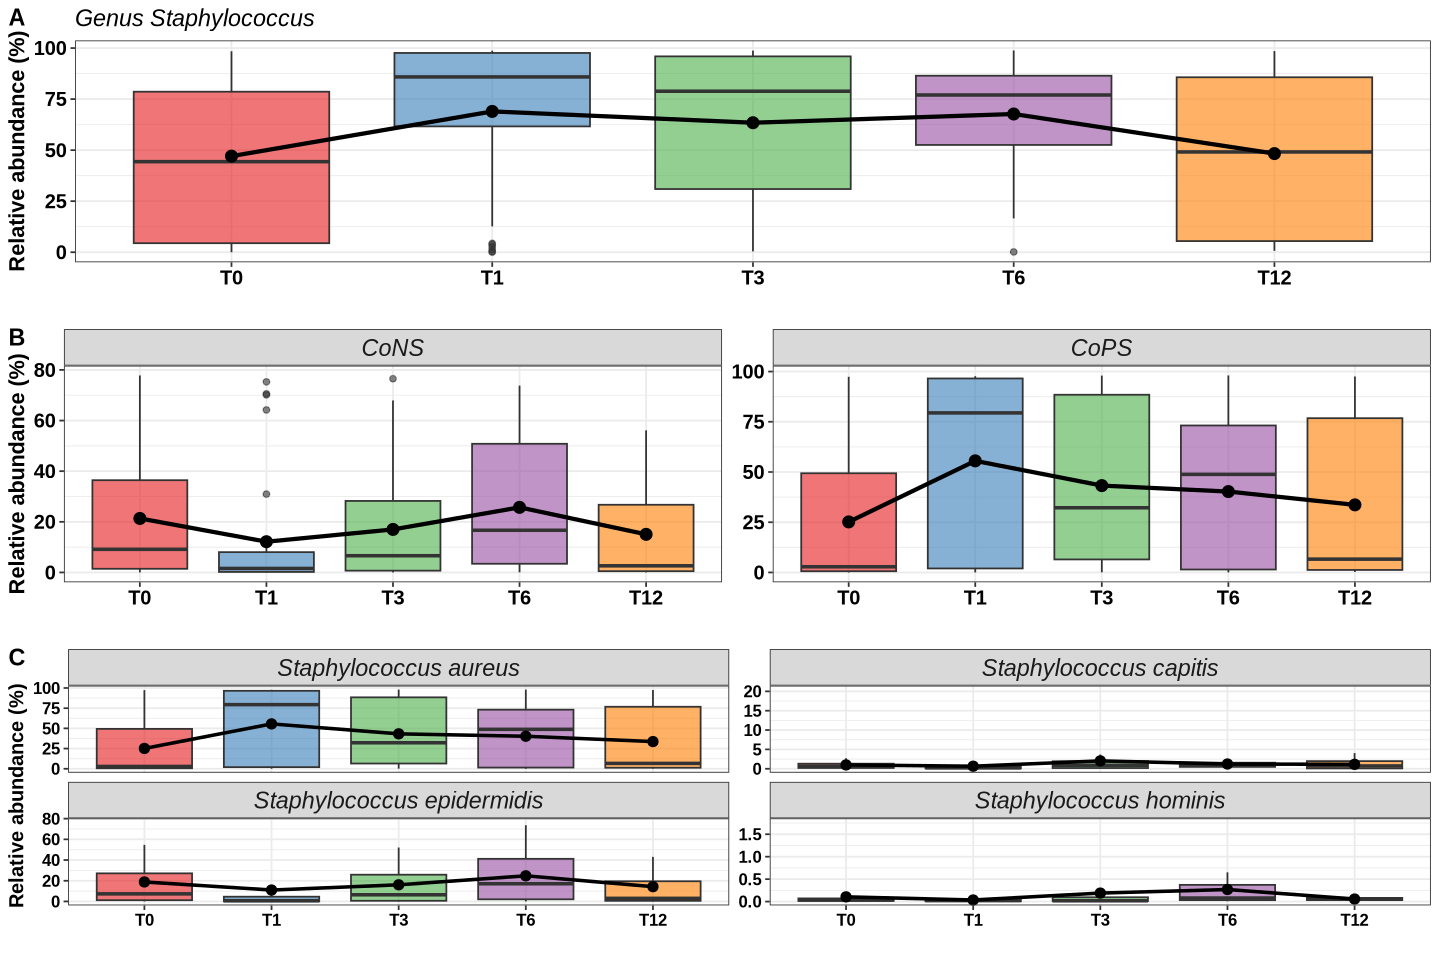

In [66]:
combined_extra_plot2 <- ggarrange(
  p_staph_genus,
  p_combined_staph,
  p_species_filtered,
  labels = c("A", "B", "C"),
  ncol = 1, nrow = 3,
  common.legend = FALSE
)

combined_extra_plot2

ggsave("combined_pannel_bars2.png", combined_extra_plot2, width = 10, height = 16, dpi = 300)

# Computing stats: assessing statistical difference in the relative abundance of main groups across timepoints

## Genera

In [102]:
print(head(ReadCounts_TaxAnnotation))

    ID_Sample           id count  Kingdom         Phylum          Class
1 0001967K_T1     AB646616     1 Bacteria      Bacillota        Bacilli
2 0001967K_T1     AF015929     4 Bacteria      Bacillota        Bacilli
3 0001967K_T1 AGEF01000005     1 Bacteria      Bacillota        Bacilli
4 0001967K_T1 AIYD01000002     2 Bacteria      Bacillota        Bacilli
5 0001967K_T1     AJ439343     1 Bacteria Actinomycetota Actinobacteria
6 0001967K_T1     AJ938182     1 Bacteria      Bacillota        Bacilli
             Order             Family           Genus
1 Staphylococcales  Staphylococcaceae  Staphylococcus
2 Staphylococcales  Staphylococcaceae  Staphylococcus
3  Lactobacillales  Carnobacteriaceae  Dolosigranulum
4 Staphylococcales  Staphylococcaceae  Staphylococcus
5  Mycobacteriales Corynebacteriaceae Corynebacterium
6 Staphylococcales  Staphylococcaceae  Staphylococcus
                               Species total_aligned RelativeAbundance SNOT22
1       Staphylococcus saccharolyticus  

In [123]:
# Prepare Your Input list and filter data
target_genera <- c(
  "Staphylococcus", "Pseudomonas", "Citrobacter", "Dolosigranulum", 
  "Escherichia-Shigella", "Streptococcus", "Haemophilus", "Corynebacterium"
)

# Filter once for all target genera
filtered_data <- ReadCounts_TaxAnnotation %>%
  filter(Genus %in% target_genera)
# Split into a named list of dataframes, one per genus
data_list <- filtered_data %>%
  group_split(Genus) %>%
  setNames(unique(filtered_data$Genus))

# Wilcoxon signed-rank test per genus (paired samples)
wilcox_results_list <- lapply(data_list, function(df) {
  df %>%
    pairwise_wilcox_test(RelativeAbundance ~ Timepoint,
                         # paired = TRUE,
                         # id = Patient,                # Pair by patient ID
                         p.adjust.method = "bonferroni") %>%
    arrange(p.adj)  # Sort by adjusted p-value
})

In [124]:
wilcox_results_list[["Corynebacterium"]]

.y.,group1,group2,n1,n2,statistic,p,p.adj,p.adj.signif
<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<chr>
RelativeAbundance,T0,T12,506,180,28549,9.97e-14,9.97e-13,****
RelativeAbundance,T12,T3,180,187,23363,1.26e-10,1.26e-09,****
RelativeAbundance,T12,T6,180,202,24421,6.85e-09,6.85e-08,****
RelativeAbundance,T1,T12,48,180,2678,5.21e-05,5.21e-04,***
RelativeAbundance,T0,T1,506,48,11518,5.55e-01,1.00e+00,ns
RelativeAbundance,T0,T3,506,187,47227,9.72e-01,1.00e+00,ns
RelativeAbundance,T0,T6,506,202,47480,1.40e-01,1.00e+00,ns
RelativeAbundance,T1,T3,48,187,4720,5.81e-01,1.00e+00,ns
RelativeAbundance,T1,T6,48,202,4832,9.73e-01,1.00e+00,ns


## Species

In [73]:
staph_species <- df_species %>%
  filter(grepl("Staphylococcus", Taxa)) %>%
  distinct(Taxa) %>%
  arrange(Taxa)

staph_species

Taxa
<chr>
Staphylococcus agnetis
Staphylococcus argenteus
Staphylococcus arlettae
Staphylococcus aureus
Staphylococcus aureus 08BA02176
Staphylococcus aureus M1016
Staphylococcus aureus M1061
Staphylococcus aureus O11
Staphylococcus aureus RF122


In [120]:
head(df_species)

# Make a df for each species of interest 
df_aureus <- df_species[grepl("Staphylococcus aureus", df_species$Taxa), ]
df_pneumoniae <- df_species[grepl("Streptococcus pneumoniae", df_species$Taxa), ]
df_citro <- df_species[grepl("Citrobacter koseri", df_species$Taxa), ]
df_influenzae <- df_species[grepl("Haemophilus influenzae", df_species$Taxa), ]
df_aeruginosa <- df_species[grepl("Pseudomonas aeruginosa", df_species$Taxa), ]
df_capitis <- df_species[grepl("Staphylococcus capitis", df_species$Taxa), ]
df_epidermidis <- df_species[grepl("Staphylococcus epidermidis", df_species$Taxa), ]
df_hominis <- df_species[grepl("Staphylococcus hominis", df_species$Taxa), ]
df_agnetis <- df_species[grepl("Staphylococcus agnetis", df_species$Taxa), ]
df_argenteus <- df_species[grepl("Staphylococcus argenteus", df_species$Taxa), ]
df_arlettae <- df_species[grepl("Staphylococcus arlettae", df_species$Taxa), ]
df_stepanovicii <- df_species[grepl("Staphylococcus stepanovicii", df_species$Taxa), ]
df_succinus <- df_species[grepl("Staphylococcus succinus", df_species$Taxa), ]
df_warneri <- df_species[grepl("Staphylococcus warneri", df_species$Taxa), ]
df_xylosus <- df_species[grepl("Staphylococcus xylosus", df_species$Taxa), ]

Taxa,ID_Sample,Timepoint,Counts,Genus,RelAbund,Taxa_clean
<chr>,<chr>,<fct>,<int>,<chr>,<dbl>,<chr>
[Propionibacterium] namnetense,0088303G_T0,T0,1,[Propionibacterium],0.01600512,[Propionibacterium] namnetense
Anaerococcus octavius,0088303G_T0,T0,4,Anaerococcus,0.06402049,Anaerococcus octavius
bacterium,0088303G_T0,T0,8,bacterium,0.12804097,NA
bacterium 1-gw1-3,0088303G_T0,T0,9,bacterium,0.14404609,bacterium 1-gw1-3
bacterium HKG213,0088303G_T0,T0,16,bacterium,0.25608195,bacterium HKG213
bacterium N47,0088303G_T0,T0,21,bacterium,0.33610755,bacterium N47


In [79]:
# Function to compute Kruskal-Wallis test and return results
compute_kw_test <- function(df, group_col = "Timepoint", value_col = "RelAbund") {
  df %>%
    kruskal_test(as.formula(paste(value_col, "~", group_col))) %>%
    adjust_pvalue(method = "bonferroni") %>%
    add_significance()
}


# Compute stats per species
kw_aureus <- compute_kw_test(df_aureus)
kw_pneumoniae <- compute_kw_test(df_pneumoniae)
kw_citro <- compute_kw_test(df_citro)
kw_influenzae <- compute_kw_test(df_influenzae)
kw_aeruginosa <- compute_kw_test(df_aeruginosa)
kw_capitis <- compute_kw_test(df_capitis)
kw_epidermidis <- compute_kw_test(df_epidermidis)
kw_hominis <- compute_kw_test(df_hominis)

In [86]:
kw_agnetis <- compute_kw_test(df_agnetis)
kw_argenteus <- compute_kw_test(df_argenteus)
kw_arlettae <- compute_kw_test(df_arlettae)
kw_succinus <- compute_kw_test(df_succinus)
kw_warneri <- compute_kw_test(df_warneri)
kw_xylosus <- compute_kw_test(df_xylosus)

In [92]:
kw_warneri
compute_dunn_test <- function(df, group_col = "Timepoint", value_col = "RelAbund") {
  df %>%
    dunn_test(as.formula(paste(value_col, "~", group_col)), p.adjust.method = "bonferroni") %>%
    add_significance()
}

# Example for aureus
dunn_warneri <- compute_dunn_test(df_warneri)
dunn_warneri

.y.,n,statistic,df,p,method,p.adj,p.adj.signif
<chr>,<int>,<dbl>,<int>,<dbl>,<chr>,<dbl>,<chr>
RelAbund,63,10.19752,4,0.0372,Kruskal-Wallis,0.0372,*


.y.,group1,group2,n1,n2,statistic,p,p.adj,p.adj.signif
<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<chr>
RelAbund,T0,T1,16,10,1.0928139,0.274475518,1.00000000,ns
RelAbund,T0,T3,16,19,0.2845390,0.775997340,1.00000000,ns
RelAbund,T0,T6,16,13,2.7352413,0.006233457,0.06233457,ns
RelAbund,T0,T12,16,5,1.6051774,0.108454776,1.00000000,ns
RelAbund,T1,T3,10,19,-0.8804635,0.378608244,1.00000000,ns
RelAbund,T1,T6,10,13,1.3808003,0.167340386,1.00000000,ns
RelAbund,T1,T12,10,5,0.6972167,0.485667196,1.00000000,ns
RelAbund,T3,T6,19,13,2.5692707,0.010191283,0.10191283,ns
RelAbund,T3,T12,19,5,1.4441424,0.148698930,1.00000000,ns


### CONS

In [60]:
head(df_cons)

ID_Sample,Timepoint,RelAbund
<chr>,<fct>,<dbl>
0001967K_T1,T1,0.20858164
0001967K_T3,T3,0.24894607
0001967K_T6,T6,0.05989549
0088303G_T0,T0,53.42509603
0088303G_T1,T1,0.89098707
0088303G_T3,T3,42.59035103


In [62]:
kw_stats_cons <- df_cons %>%
  kruskal_test(RelAbund ~ Timepoint) %>%
  adjust_pvalue(method = "bonferroni") %>%
  arrange(p.adj)

dunn_posthoc_cons <- df_cons %>%
  dunn_test(RelAbund ~ Timepoint, p.adjust.method = "bonferroni") %>%
  arrange(p.adj)

In [93]:
kw_stats_cons
dunn_posthoc_cons

.y.,n,statistic,df,p,method,p.adj
<chr>,<int>,<dbl>,<int>,<dbl>,<chr>,<dbl>
RelAbund,150,8.877866,4,0.0642,Kruskal-Wallis,0.0642


.y.,group1,group2,n1,n2,statistic,p,p.adj,p.adj.signif
<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<chr>
RelAbund,T1,T6,31,27,2.6948349,0.007042352,0.07042352,ns
RelAbund,T0,T1,36,31,-2.1288890,0.033263443,0.33263443,ns
RelAbund,T6,T12,27,22,-1.7876444,0.073833395,0.73833395,ns
RelAbund,T0,T3,36,34,-0.8085267,0.418787416,1.00000000,ns
RelAbund,T0,T6,36,27,0.7375161,0.460808530,1.00000000,ns
RelAbund,T0,T12,36,22,-1.2034569,0.228799551,1.00000000,ns
RelAbund,T1,T3,31,34,1.3218930,0.186203783,1.00000000,ns
RelAbund,T1,T12,31,22,0.7029160,0.482108099,1.00000000,ns
RelAbund,T3,T6,34,27,1.4784745,0.139280807,1.00000000,ns
